In [1]:
import pandas as pd
import numpy as np
from pymatgen.core import Composition

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

# Splitting data into training and testing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['Times New Roman'],
    "font.size": 24,
    'axes.unicode_minus': False 
}
rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False  
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300 

# Processing datasets

In [2]:
# https://www.snumat.com/¶
hse_data = pd.read_csv('./data/hse_data.csv', index_col=0)
hse_data

,Material,Chemical_formula,Band_gap_HSE,Direct_or_indirect_HSE,Band_gap_GGA,Space_group_cif,Free_energy
0,Ge1Se8V4,Ge(V4Se8),0.000000,Indirect,0.000000,44.0,-5.897176
1,Cu2Ge1Se3,Cu2(GeSe3),0.357144,Indirect,0.057361,9.0,-3.574910
2,Cl4Co1Na2,Na2(CoCl4),4.477341,Direct,2.780673,62.0,-3.567538
3,Cr1Na1Se2,NaCrSe2,1.138949,Indirect,0.407413,166.0,-4.752246
4,Al2Fe3Si4,AlFe1.50Si2,0.000000,Indirect,0.000000,63.0,-6.420703
...,...,...,...,...,...,...,...
13714,Ga2In6O8Pt1,(PtIn6)(GaO4)2,1.503397,Indirect,0.613842,225.0,-5.429347
13715,Ge1In7Ir1O8,IrIn7GeO8,1.276845,Indirect,0.422346,216.0,-5.519259
13716,Ge1Mn1O4Zn1,ZnMn(GeO4),2.672193,Indirect,1.597849,62.0,-6.256881
13717,Ge2Mn1O7Sr2,Sr2Mn(Ge2O7),3.170080,Direct,2.025250,113.0,-6.705552


In [3]:
hse_data = hse_data[['Material','Band_gap_HSE','Band_gap_GGA','Space_group_cif','Free_energy']]
hse_data.columns = ['formula', 'HSE', 'GGA', 'spacegroup','free_energy']
hse_data['index'] = hse_data.index
hse_data

,formula,HSE,GGA,spacegroup,free_energy,index
0,Ge1Se8V4,0.000000,0.000000,44.0,-5.897176,0
1,Cu2Ge1Se3,0.357144,0.057361,9.0,-3.574910,1
2,Cl4Co1Na2,4.477341,2.780673,62.0,-3.567538,2
3,Cr1Na1Se2,1.138949,0.407413,166.0,-4.752246,3
4,Al2Fe3Si4,0.000000,0.000000,63.0,-6.420703,4
...,...,...,...,...,...,...
13714,Ga2In6O8Pt1,1.503397,0.613842,225.0,-5.429347,13714
13715,Ge1In7Ir1O8,1.276845,0.422346,216.0,-5.519259,13715
13716,Ge1Mn1O4Zn1,2.672193,1.597849,62.0,-6.256881,13716
13717,Ge2Mn1O7Sr2,3.170080,2.025250,113.0,-6.705552,13717


In [4]:
mp_data = pd.read_csv("./data/mp_data_new.csv")
mp_data = mp_data.rename(columns={'formula_pretty':'formula','symmetry':'spacegroup','band_gap':'GGA'})
mp_data = mp_data[['formula','spacegroup','GGA','formation_energy_per_atom','energy_above_hull']]
mp_data = mp_data.dropna(subset=['formula','spacegroup'])
mp_data['index'] = mp_data.index

In [5]:
# Convert to the same chemical formula format
hse_data['formula'] = hse_data['formula'].map(lambda x:Composition(x).reduced_formula)
mp_data['formula'] = mp_data['formula'].map(lambda x:Composition(x).reduced_formula)

In [6]:
#pick out some data https://docs.materialsproject.org/methodology/materials-methodology/electronic-structure/
mp_data['composition'] = mp_data['formula'].map(Composition)
mp_data['is_GGA_U'] = mp_data['composition'].map(lambda x : 1 if ('Co' in x and 'O' in x) or ('Co' in x and 'F' in x)
                                                 or ('Cr'in x and 'O' in x) or ('Cr' in x and 'F' in x)
                                                 or ('Fe'in x and 'O' in x) or ('Fe' in x and 'F' in x)
                                                 or ('Mn'in x and 'O' in x and x.reduced_formula != 'Mn2O3') or ('Mn' in x and 'F' in x)
                                                 or ('Mo'in x and 'O' in x) or ('Mo' in x and 'F' in x)
                                                 or ('Ni'in x and 'O' in x) or ('Ni' in x and 'F' in x)
                                                 or ('V'in x and 'O' in x and x.reduced_formula != 'VO') or ('V' in x and 'F' in x)
                                                 or ('W'in x and 'O' in x) or ('W' in x and 'F' in x)
                                                 else 0
                                                )
mp_data['is_GGA_U'].value_counts()

0    111777
1     42938
Name: is_GGA_U, dtype: int64

In [7]:
mp_data_U = mp_data[mp_data['is_GGA_U']==1]
mp_data_non_U = mp_data[mp_data['is_GGA_U']==0]

In [8]:
# take the intersection
inner_val = pd.merge(hse_data,mp_data_non_U, on=['formula','spacegroup'], how='inner')
inner_val

,formula,HSE,GGA_x,spacegroup,free_energy,index_x,GGA_y,formation_energy_per_atom,energy_above_hull,index_y,composition,is_GGA_U
0,Cu2GeSe3,0.357144,0.057361,9.0,-3.574910,1,0.0000,-0.477014,0.004076,145377,"(Cu, Ge, Se)",0
1,Na2CoCl4,4.477341,2.780673,62.0,-3.567538,2,0.0192,-1.650927,0.000000,101779,"(Na, Co, Cl)",0
2,NaCrSe2,1.138949,0.407413,166.0,-4.752246,3,0.7808,-1.044310,0.000000,66800,"(Na, Cr, Se)",0
3,Al2Fe3Si4,0.000000,0.000000,63.0,-6.420703,4,0.0000,-0.398392,0.010081,135106,"(Al, Fe, Si)",0
4,LaNi4B,0.000000,0.000000,191.0,-6.000872,5,0.0000,-0.416482,0.000000,124033,"(La, Ni, B)",0
...,...,...,...,...,...,...,...,...,...,...,...,...
14492,LaCuTeO,2.246626,1.417926,129.0,-5.791982,13707,1.1839,-2.177789,0.008628,82121,"(La, Cu, Te, O)",0
14493,La3CuS3O2,1.871609,1.088934,62.0,-6.802721,13708,0.9670,-2.742169,0.000000,84374,"(La, Cu, S, O)",0
14494,La3GaS5O,1.968560,1.153778,62.0,-6.389724,13713,1.2434,-2.395346,0.000000,9807,"(La, Ga, S, O)",0
14495,In6Ga2PtO8,1.503397,0.613842,225.0,-5.429347,13714,0.5672,-1.778338,0.000000,147398,"(In, Ga, Pt, O)",0


In [9]:
index_x = inner_val['index_x'].drop_duplicates(keep='first')
index_y = inner_val['index_y'].drop_duplicates(keep='first')
hse_data = hse_data.drop(index=index_x)
mp_data_non_U = mp_data_non_U.drop(index=index_y)

In [10]:
# Handle data with the same chemical formula and space group
def handle_with_the_same_formula_and_spacegroup(df):
   
    formula_repeat_data = df[df[["formula"]].duplicated(keep=False)]
    formula_repeat_data = formula_repeat_data.sort_values('formula')
   
    formula_and_spacegroup_repeat_data = formula_repeat_data[formula_repeat_data[["formula",'spacegroup']].duplicated(keep=False)]
    formula_and_spacegroup_repeat_data = formula_and_spacegroup_repeat_data.sort_values('formula')
    
    formula_and_spacegroup_repeat_data['index'] = formula_and_spacegroup_repeat_data.index
    keeped_repeat_spacegroup_data = pd.DataFrame()
    if 'formation_energy_per_atom' in df.columns and 'energy_above_hull' in df.columns:
        keeped_repeat_spacegroup_data = formula_and_spacegroup_repeat_data.groupby(['formula','spacegroup'],
                                                                                   as_index=False).min(['formation_energy_per_atom',
                                                                                                        'energy_above_hull'])
    elif 'free_energy' in df.columns:
        keeped_repeat_spacegroup_data = formula_and_spacegroup_repeat_data.groupby(['formula','spacegroup'],as_index=False).min(['free_energy'])
    
    keeped_repeat_spacegroup_data.index = keeped_repeat_spacegroup_data['index']
    keeped_repeat_spacegroup_data = keeped_repeat_spacegroup_data.drop(columns='index')
    
    droped_repeat_spacegroup_data = formula_repeat_data.drop(index = formula_and_spacegroup_repeat_data.index)
    df = df.drop(index = formula_and_spacegroup_repeat_data.index)
   
    df = pd.concat([df,keeped_repeat_spacegroup_data],axis=0)
    return df

In [11]:
hse_data = handle_with_the_same_formula_and_spacegroup(hse_data)
mp_data_U = handle_with_the_same_formula_and_spacegroup(mp_data_U)
mp_data_non_U = handle_with_the_same_formula_and_spacegroup(mp_data_non_U)
print(hse_data.shape,mp_data_U.shape,mp_data_non_U.shape)

(2222, 6) (32296, 8) (91813, 8)


In [12]:
def remove_single_element(data):
    # delete a single element
    data['composition'] = data['formula'].map(Composition)
    data['is_single_element'] = data['composition'].map(lambda x: 1 if len(x)==1 else 0)
    data = data[data['is_single_element']==0]
    data = data.drop(columns = 'is_single_element')
    return data

In [13]:
hse_data = remove_single_element(hse_data)
mp_data_U = remove_single_element(mp_data_U)
mp_data_non_U = remove_single_element(mp_data_non_U)
inner_val = remove_single_element(inner_val)
print(hse_data.shape,mp_data_U.shape,mp_data_non_U.shape,inner_val.shape)

(2204, 7) (32296, 8) (91305, 8) (14324, 12)


In [14]:
# Keep the closest result calculated by GGA
inner_val['GGA_err'] = np.abs(inner_val['GGA_x'] -  inner_val['GGA_y'])
inner_val = inner_val.groupby(['formula','spacegroup'],as_index=False).min(['GGA_err'])
keeped_data = inner_val
inner_val

,formula,spacegroup,HSE,GGA_x,free_energy,index_x,GGA_y,formation_energy_per_atom,energy_above_hull,index_y,is_GGA_U,GGA_err
0,Ag(AuF4)2,14.0,2.060208,0.29665,-3.233511,2126,0.2585,-1.385379,0.000000,108057,0,0.03815
1,Ag(Bi2S3)3,12.0,0.000000,0.00000,-4.253158,990,0.0000,-0.592917,0.029380,139197,0,0.00000
2,Ag(CO)2,15.0,2.428665,1.20222,-6.585129,11992,0.7248,-0.646890,0.415317,131244,0,0.47742
3,Ag(Mo3Se4)2,148.0,0.000000,0.00000,-6.886230,1822,0.0000,-0.714146,0.076030,24039,0,0.00000
4,Ag(MoSe)3,176.0,0.000000,0.00000,-6.903092,11880,0.0000,-0.518753,0.116210,12579,0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
10647,ZrVGe,139.0,0.000000,0.00000,-7.972034,12427,0.0000,-0.662724,0.000000,58118,0,0.00000
10648,ZrW2,227.0,0.000000,0.00000,-11.656033,10452,0.0000,-0.145862,0.000000,92329,0,0.00000
10649,ZrZn,221.0,0.000000,0.00000,-5.101354,11178,0.0000,-0.287190,0.000000,89434,0,0.00000
10650,ZrZn2,227.0,0.000000,0.00000,-3.880027,5652,0.0000,-0.302553,0.000000,96359,0,0.00000


<AxesSubplot:>

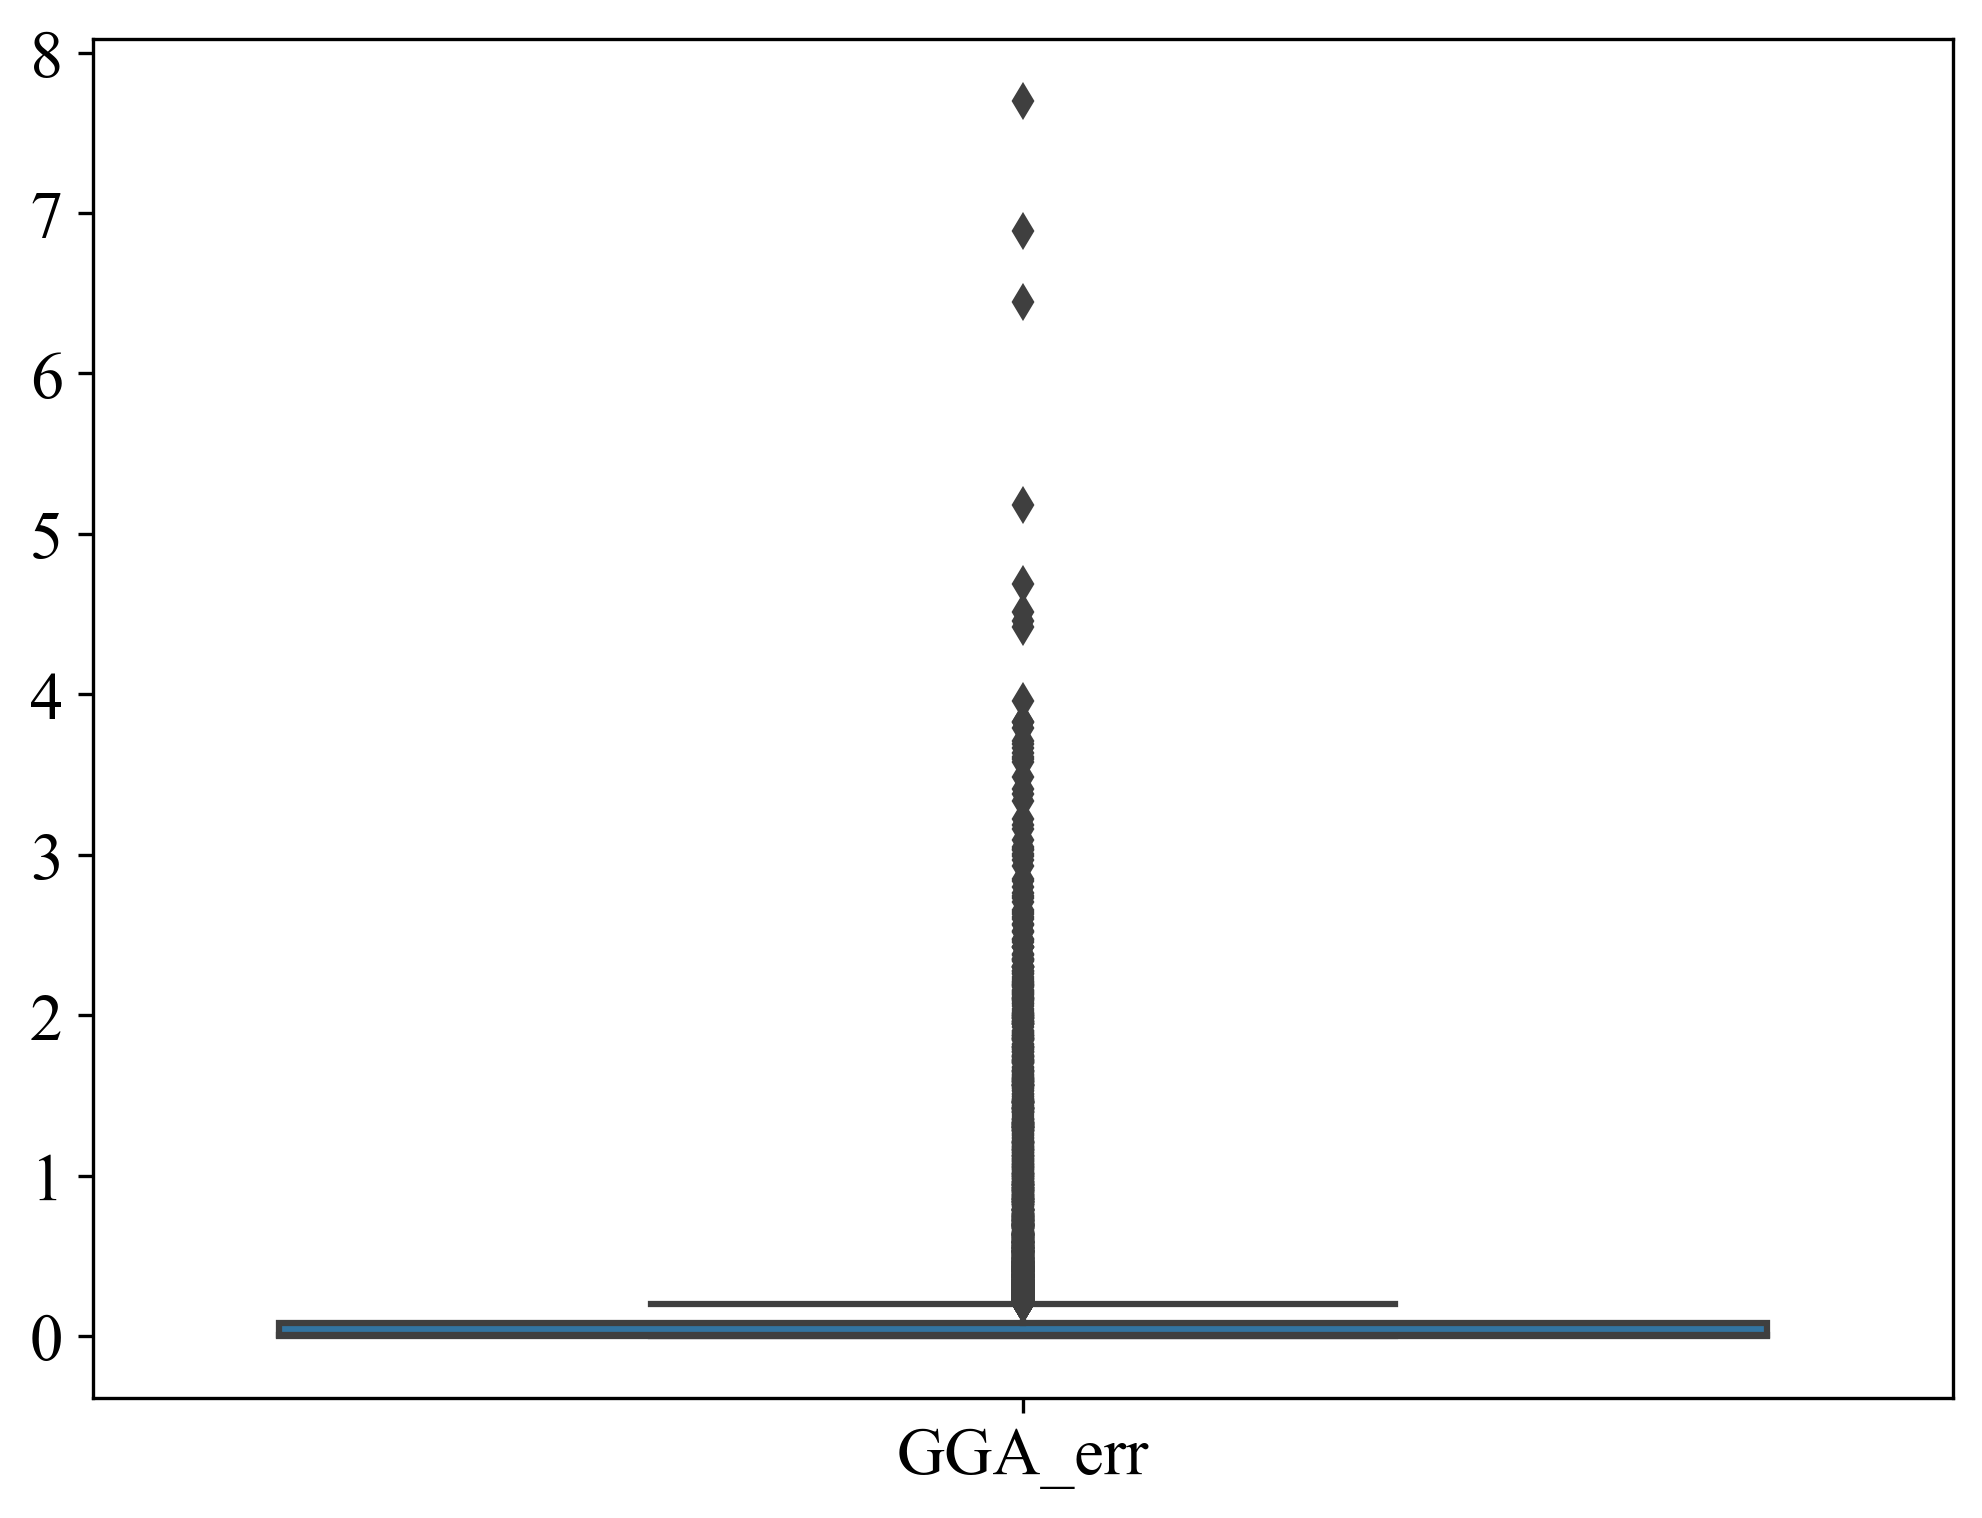

In [15]:
sns.boxplot(inner_val[['GGA_err']])

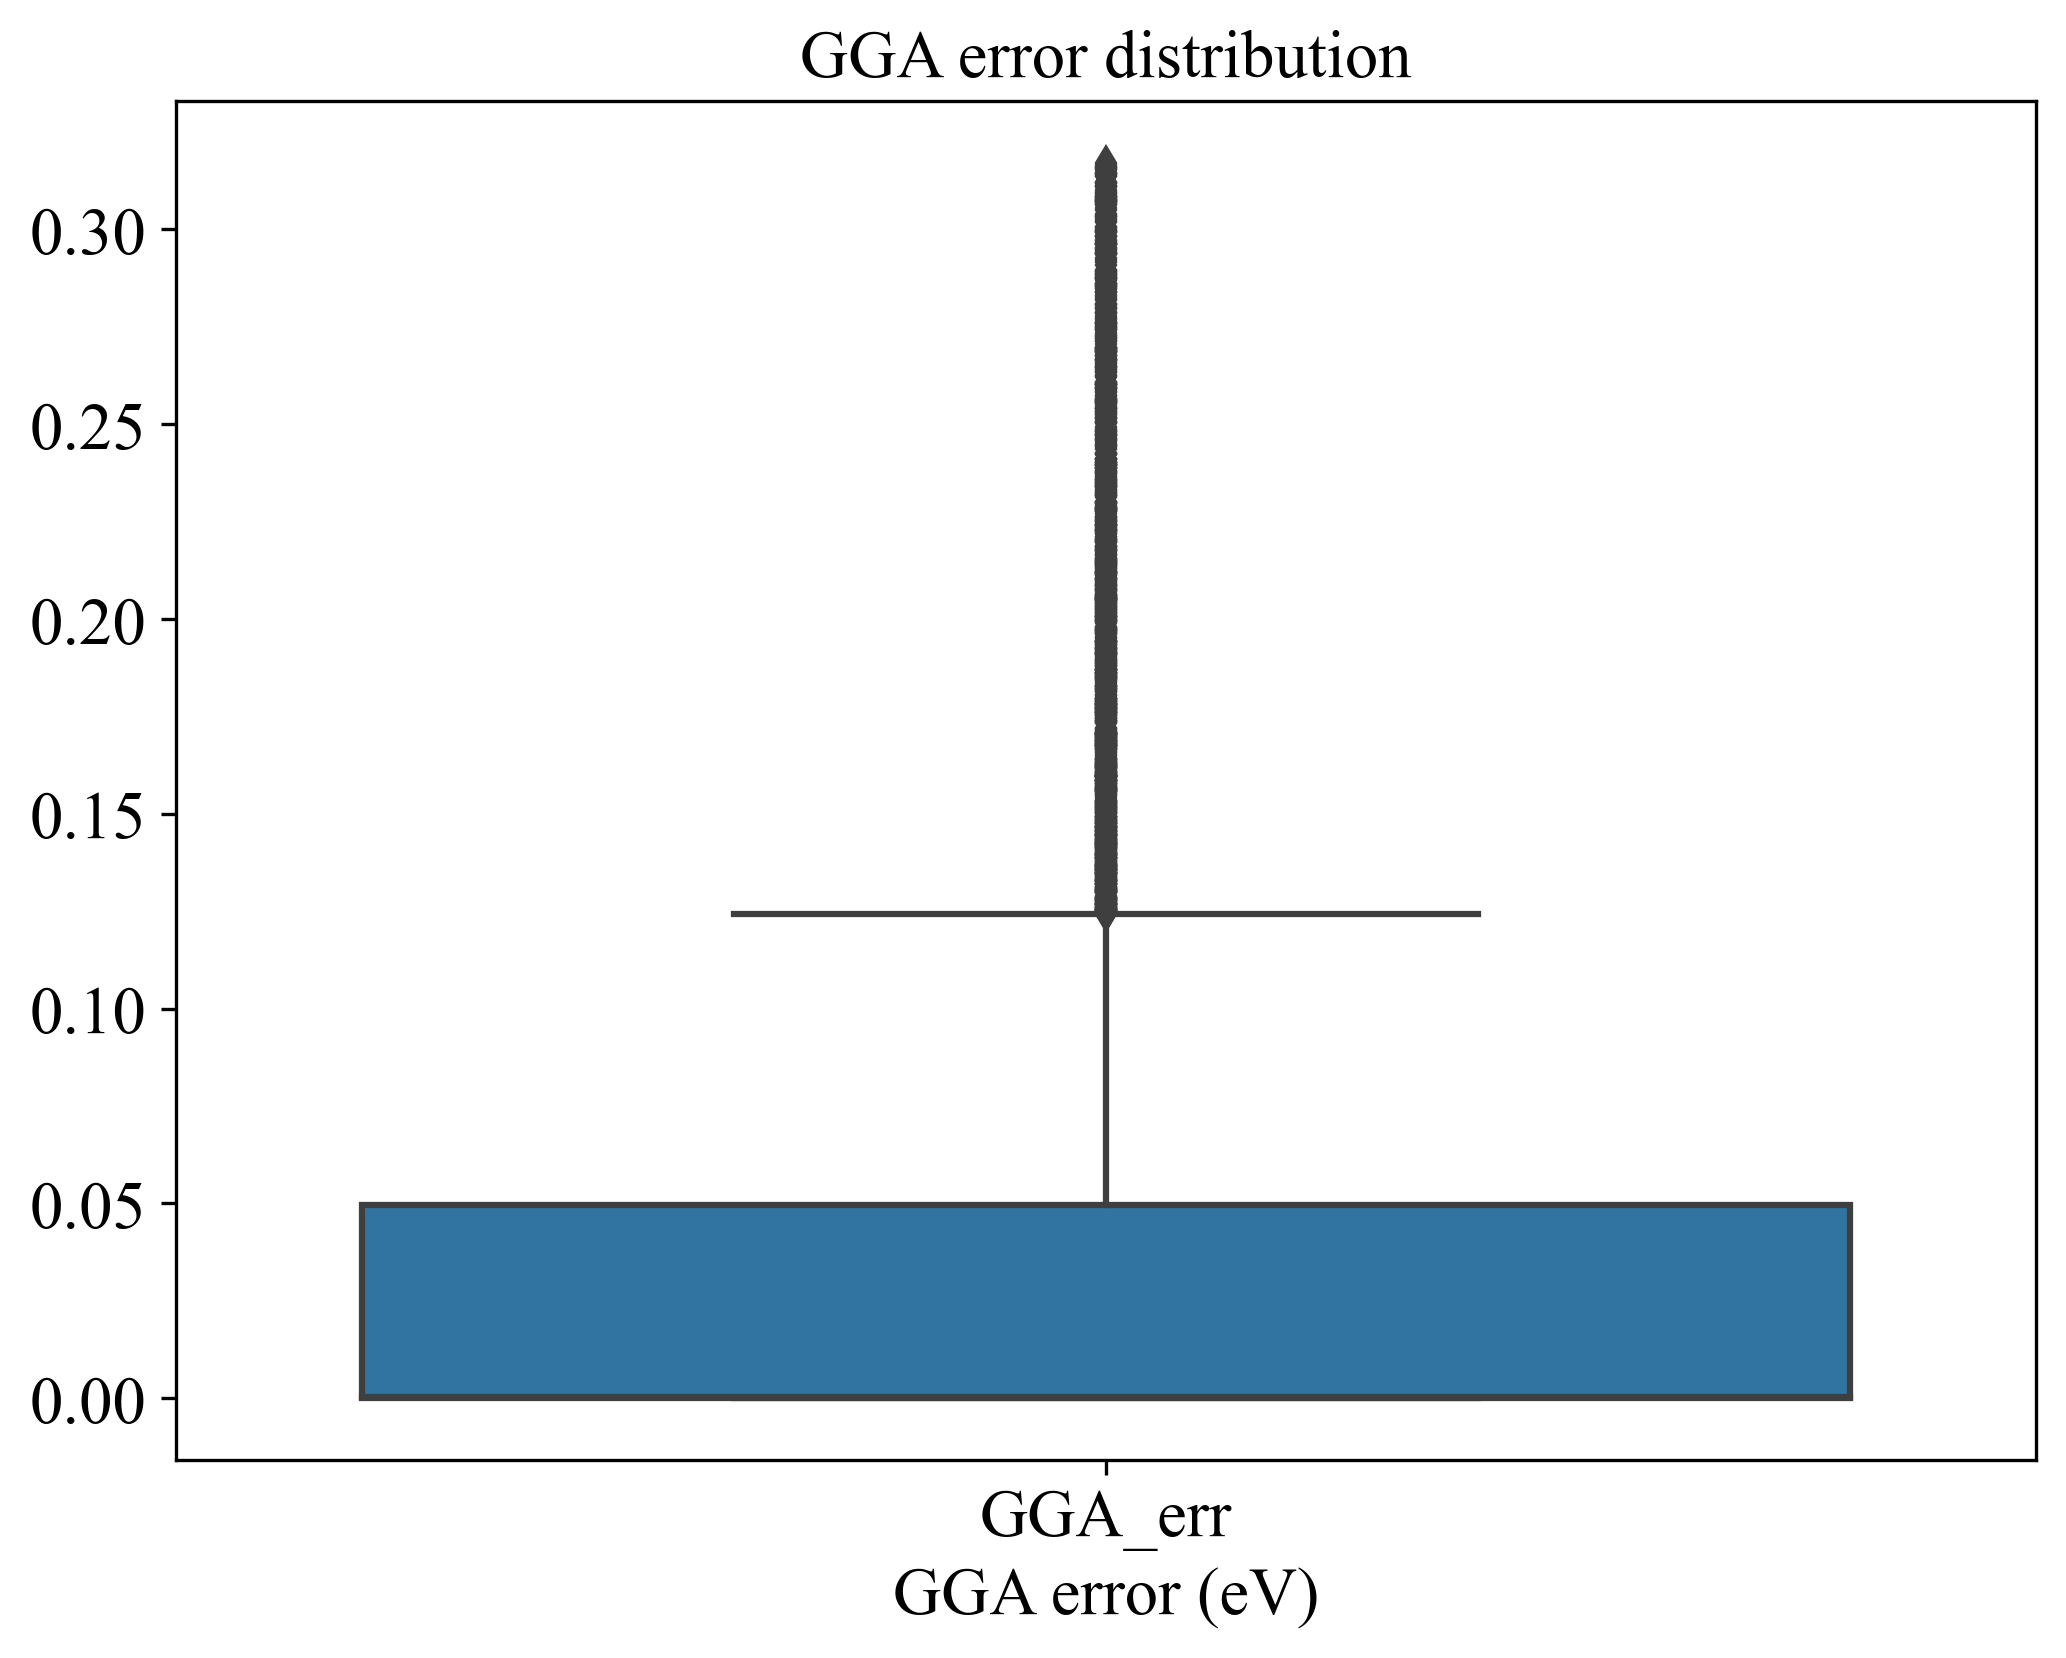

In [16]:
first_quartile = inner_val['GGA_err'].describe()['25%']
third_quartile = inner_val['GGA_err'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

inner_val = inner_val[(inner_val['GGA_err'] > (first_quartile - 3 * iqr)) &
            (inner_val['GGA_err'] < (third_quartile + 3 * iqr))]
sns.boxplot(inner_val[['GGA_err']].dropna());
plt.xlabel('GGA error (eV)')
plt.title('GGA error distribution');

In [17]:
inner_val['GGA_err'].describe()

count    9666.000000
mean        0.038454
std         0.065829
min         0.000000
25%         0.000000
50%         0.000273
75%         0.049725
max         0.317100
Name: GGA_err, dtype: float64

In [18]:
# data for ml
data = inner_val[['formula','spacegroup','HSE','GGA_y']]
data = data.rename(columns={'GGA_y':'GGA'})
data

,formula,spacegroup,HSE,GGA
0,Ag(AuF4)2,14.0,2.060208,0.2585
1,Ag(Bi2S3)3,12.0,0.000000,0.0000
3,Ag(Mo3Se4)2,148.0,0.000000,0.0000
4,Ag(MoSe)3,176.0,0.000000,0.0000
5,Ag(TeMo)6,12.0,0.000000,0.0000
...,...,...,...,...
10647,ZrVGe,139.0,0.000000,0.0000
10648,ZrW2,227.0,0.000000,0.0000
10649,ZrZn,221.0,0.000000,0.0000
10650,ZrZn2,227.0,0.000000,0.0000


In [19]:
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
if 'composition' not in data.columns:
    data['composition'] = data['formula'].map(Composition)
data = feature_calculators.featurize_dataframe(data, col_id='composition');
feature_labels = feature_calculators.feature_labels()

MultipleFeaturizer:   0%|          | 0/9666 [00:00<?, ?it/s]

In [20]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''  
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    return x

In [21]:
# 剔除共线性特征
X = data[feature_labels]
print('before,',X.shape)
X = remove_collinear_features(X, 0.8);
print('after,',X.shape)
feature_labels = X.columns

before, (9666, 145)
after, (9666, 62)


In [22]:
if 'GGA' not in feature_labels:
    feature_labels = feature_labels.insert(-1,'GGA')
if 'spacegroup' not in feature_labels:
    feature_labels = feature_labels.insert(-1,'spacegroup')

# classification

## select features

In [23]:
X = data[feature_labels]
y = data['HSE'].map(lambda x:1 if x==0 else 0)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [24]:
# 模型的特征选择
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
model=lgb.LGBMClassifier(n_jobs=-1)
model.fit(X_train, y_train)
feature_importance=pd.DataFrame()
feature_importance['features'] = feature_labels
feature_importance['feature_importances'] = model.feature_importances_
threshold = np.sort(feature_importance['feature_importances'].values)
score = []
n_features = []
cols = []
for i in threshold:
    selector = SelectFromModel(model,threshold=i)
    X_embedded = selector.fit_transform(X_train, y_train)
    once = cross_val_score(model,X_embedded,y_train,cv=5,scoring="roc_auc",n_jobs=-1).mean()#交叉验证
    score.append(once)
    n_features.append(X_embedded.shape[1])
    cols.append(X.columns[selector.get_support()])
result = pd.DataFrame({"col":cols,"score":score,"n_features":n_features})
result

,col,score,n_features
0,"Index(['0-norm', '2-norm', '3-norm', 'MagpieDa...",0.990283,64
1,"Index(['0-norm', '2-norm', '3-norm', 'MagpieDa...",0.990283,64
2,"Index(['0-norm', '2-norm', '3-norm', 'MagpieDa...",0.990283,64
3,"Index(['0-norm', '2-norm', '3-norm', 'MagpieDa...",0.990283,64
4,"Index(['0-norm', '2-norm', '3-norm', 'MagpieDa...",0.990283,64
...,...,...,...
59,"Index(['MagpieData mean Number', 'MagpieData m...",0.986443,5
60,"Index(['MagpieData mean MendeleevNumber', 'Mag...",0.986668,4
61,"Index(['MagpieData mean NpUnfilled', 'GGA', 's...",0.984152,3
62,"Index(['MagpieData mean NpUnfilled', 'spacegro...",0.872611,2


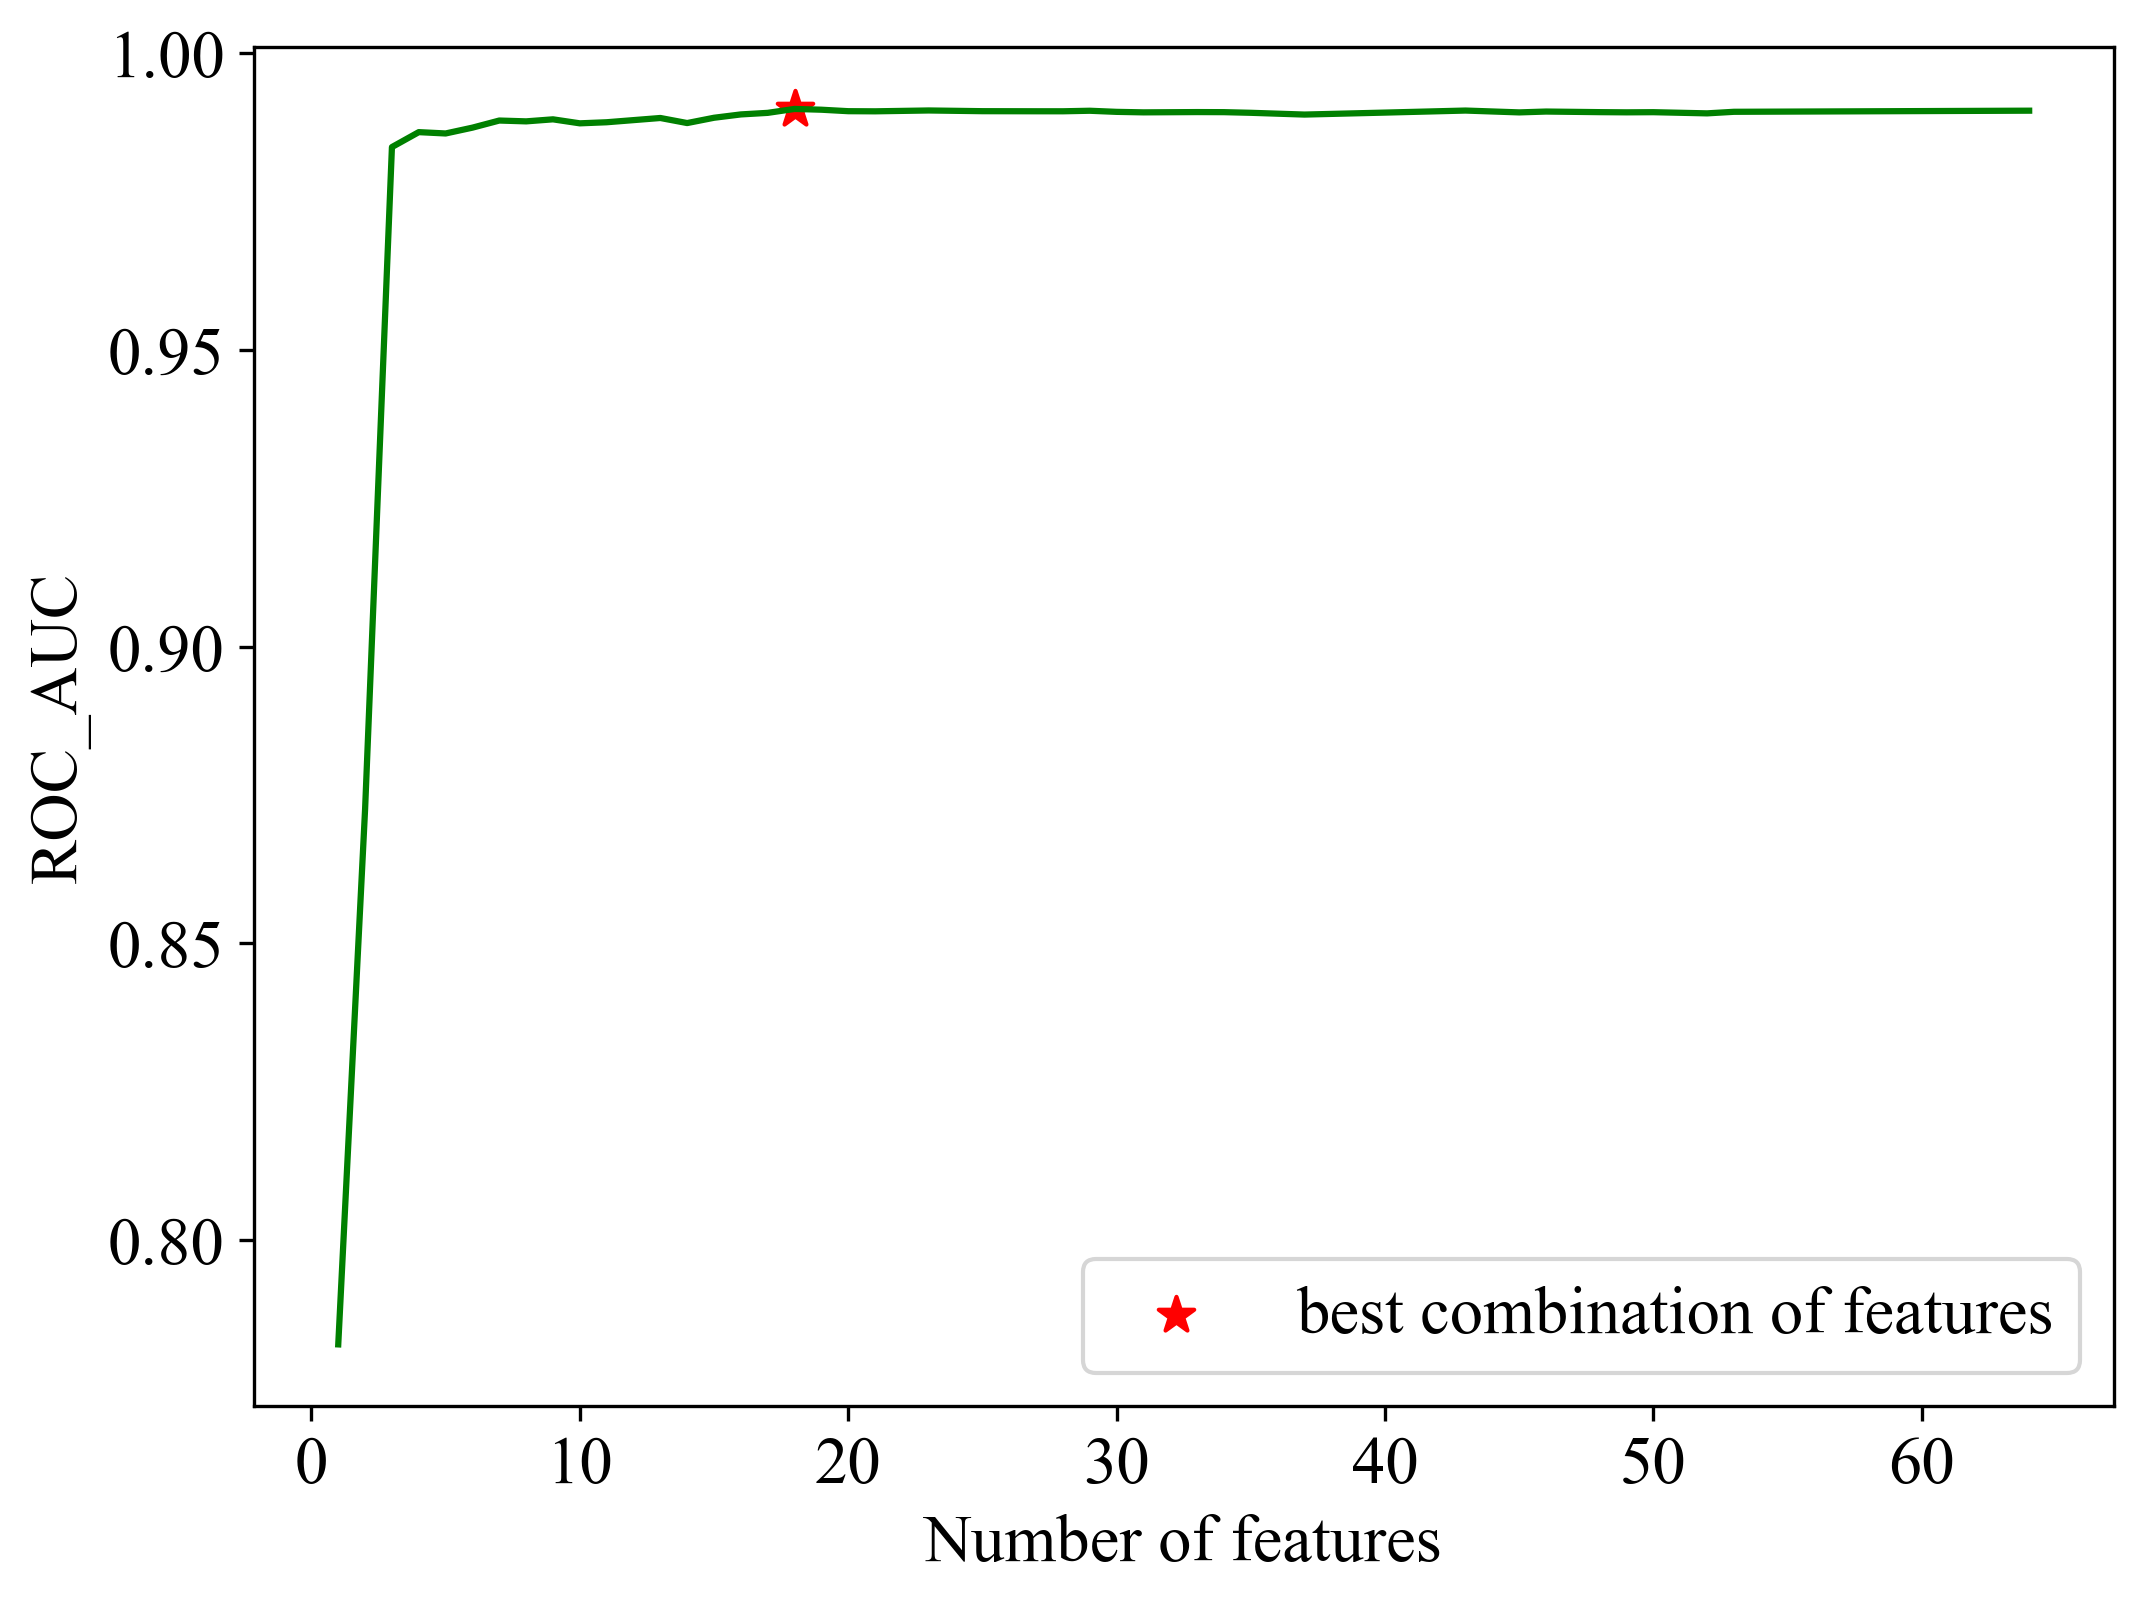

In [25]:
f_fig, f_ax = plt.subplots(figsize=(8, 6))
to_select = result[result['score']>0.99]
to_select = to_select.sort_values(by='n_features',ascending=True)
f_ax.scatter(to_select.iloc[0]['n_features'],to_select.iloc[0]['score'],marker='*',
            s=80,c='r',label='best combination of features')
f_ax.plot(n_features,score, color='g')
# plt.axhline(y=to_select.iloc[0]['score'],linestyle="--",color='grey')
# plt.axvline(x=to_select.iloc[0]['n_features'],linestyle="--",color='grey')
f_ax.set_xlabel("Number of features"), plt.ylabel("ROC_AUC")
f_ax.legend()
plt.show()
f_fig.savefig('./figures/figure1.png', dpi=300, bbox_inches='tight')

In [26]:
feature_labels = to_select.iloc[0]['col']
X_train = X_train[feature_labels]
X_test = X_test[feature_labels]
X_train.shape, X_test.shape

((7732, 18), (1934, 18))

In [28]:
from bayes_opt import BayesianOptimization
def lgb_f1_cv(num_leaves,max_depth,learning_rate,n_estimators,min_split_gain,min_data_in_leaf,subsample,colsample_bytree,
              reg_alpha,reg_lambda):
    model = lgb.LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=int(num_leaves),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        objective='binary', # 默认是二分类
        min_split_gain=min_split_gain,
        min_data_in_leaf=int(min_data_in_leaf),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
        silent=True,
        n_jobs=-1,
    )
    score = cross_val_score(model,X_train,y_train,cv=5,scoring='roc_auc',n_jobs=-1).mean()

    return score

In [29]:
pbounds = {'num_leaves': (2, 100),
           'learning_rate': (0.001, 0.1),
           'n_estimators': (100, 2500),
           'max_depth': (1, 100),
           'min_data_in_leaf':(1,100),
           'min_split_gain':(0,1),
           'subsample': (0.1, 1),
           'colsample_bytree': (0.1, 1),
           'reg_alpha': (0, 1),
           'reg_lambda': (0, 1)}

optimizer = BayesianOptimization(
    f=lgb_f1_cv,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(
    n_iter=100
)

print(optimizer.max) # 打印出找到的最佳参数组合和对应的分数

|   iter    |  target   | colsam... | learni... | max_depth | min_da... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9901    | 0.4371    | 0.09512   | 73.47     | 60.27     | 0.156     | 474.4     | 7.692     | 0.8662    | 0.6011    | 0.7373    |
| 2         | 0.9898    | 0.1185    | 0.09702   | 83.41     | 22.02     | 0.1818    | 540.2     | 31.82     | 0.5248    | 0.4319    | 0.3621    |
| 3         | 0.9906    | 0.6507    | 0.01481   | 29.92     | 37.27     | 0.4561    | 1.984e+03 | 21.57     | 0.5142    | 0.5924    | 0.1418    |
| 4         | 0.9903    | 0.6468    | 0.01788   | 7.44      | 94.94     | 0.9656    | 2.04e+03  | 31.85     | 0.09767   | 0.6842    | 0.4961    |
| 5         | 0.9898    | 0.2098    | 0.05002   | 4.404     | 91.02     | 0.2588    | 1.69e+03  | 32.55     | 0.5201    | 0.

| 34        | 0.9907    | 0.6849    | 0.07798   | 26.66     | 9.088     | 0.9984    | 188.3     | 70.92     | 0.186     | 0.6531    | 0.3517    |
| 35        | 0.9903    | 0.2895    | 0.09155   | 35.08     | 40.98     | 0.7072    | 218.9     | 70.83     | 0.7597    | 0.2563    | 0.46      |
| 36        | 0.9908    | 0.4558    | 0.05629   | 52.18     | 8.334     | 0.01452   | 191.1     | 84.14     | 0.2852    | 0.2284    | 0.4547    |
| 37        | 0.9904    | 0.2504    | 0.05894   | 57.31     | 9.311     | 0.405     | 201.4     | 81.59     | 0.5214    | 0.9787    | 0.2167    |
| 38        | 0.991     | 0.7665    | 0.03893   | 21.75     | 34.84     | 0.2977    | 219.2     | 74.38     | 0.2066    | 0.07473   | 0.6803    |
| 39        | 0.991     | 0.5709    | 0.03124   | 21.96     | 15.75     | 0.5623    | 195.2     | 63.05     | 0.1303    | 0.8697    | 0.5446    |
| 40        | 0.9908    | 0.4266    | 0.07385   | 31.93     | 16.37     | 0.6007    | 198.5     | 61.74     | 0.5545    | 0.

| 68        | 0.9902    | 0.985     | 0.06957   | 89.57     | 79.18     | 0.1411    | 424.0     | 23.44     | 0.1046    | 0.3211    | 0.5496    |
| 69        | 0.9906    | 0.4179    | 0.03641   | 84.45     | 83.27     | 0.3653    | 513.5     | 97.43     | 0.8954    | 0.429     | 0.6825    |
| 70        | 0.9905    | 0.4108    | 0.06883   | 12.0      | 13.96     | 0.9898    | 829.7     | 43.39     | 0.1977    | 0.9369    | 0.2381    |
| 71        | 0.9903    | 0.2506    | 0.084     | 97.59     | 43.98     | 0.5795    | 988.4     | 29.53     | 0.7661    | 0.7639    | 0.28      |
| 72        | 0.9899    | 0.1908    | 0.009571  | 57.15     | 66.67     | 0.7685    | 1.323e+03 | 75.66     | 0.2432    | 0.4417    | 0.4094    |
| 73        | 0.9908    | 0.6427    | 0.08765   | 86.89     | 73.24     | 0.2164    | 2.461e+03 | 75.37     | 0.03376   | 0.9057    | 0.2169    |
| 74        | 0.9904    | 0.8906    | 0.03672   | 7.19      | 38.24     | 0.4438    | 808.0     | 22.97     | 0.203     | 0.

| 102       | 0.9884    | 0.3725    | 0.0632    | 1.137     | 80.56     | 0.3691    | 1.665e+03 | 25.63     | 0.734     | 0.8933    | 0.5332    |
| 103       | 0.9908    | 0.7163    | 0.04308   | 40.99     | 25.37     | 0.4446    | 2.199e+03 | 27.92     | 0.1398    | 0.3012    | 0.6965    |
| 104       | 0.9903    | 0.3033    | 0.0288    | 55.98     | 74.49     | 0.9042    | 1.175e+03 | 95.36     | 0.5303    | 0.3969    | 0.5316    |
| 105       | 0.9906    | 0.8033    | 0.09074   | 49.44     | 23.55     | 0.1364    | 889.5     | 62.11     | 0.6426    | 0.9205    | 0.7453    |
{'target': 0.9912665235011915, 'params': {'colsample_bytree': 0.6788047285244513, 'learning_rate': 0.05571891121006615, 'max_depth': 26.407101978640824, 'min_data_in_leaf': 11.280893682994487, 'min_split_gain': 0.47849737190868136, 'n_estimators': 203.19748973698825, 'num_leaves': 72.80866602369152, 'reg_alpha': 0.03366612582176187, 'reg_lambda': 0.20033944814511684, 'subsample': 0.4667506929331463}}


In [30]:
params = optimizer.max['params']
params['n_estimators'] = int(params['n_estimators'])
params['num_leaves'] = int(params['num_leaves'])
params['max_depth'] = int(params['max_depth'])
params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
model = lgb.LGBMClassifier(
        boosting_type='gbdt',
        **params,
        random_state=42,
        n_jobs=-1,
    )

In [31]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_indices = kf.split(X_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


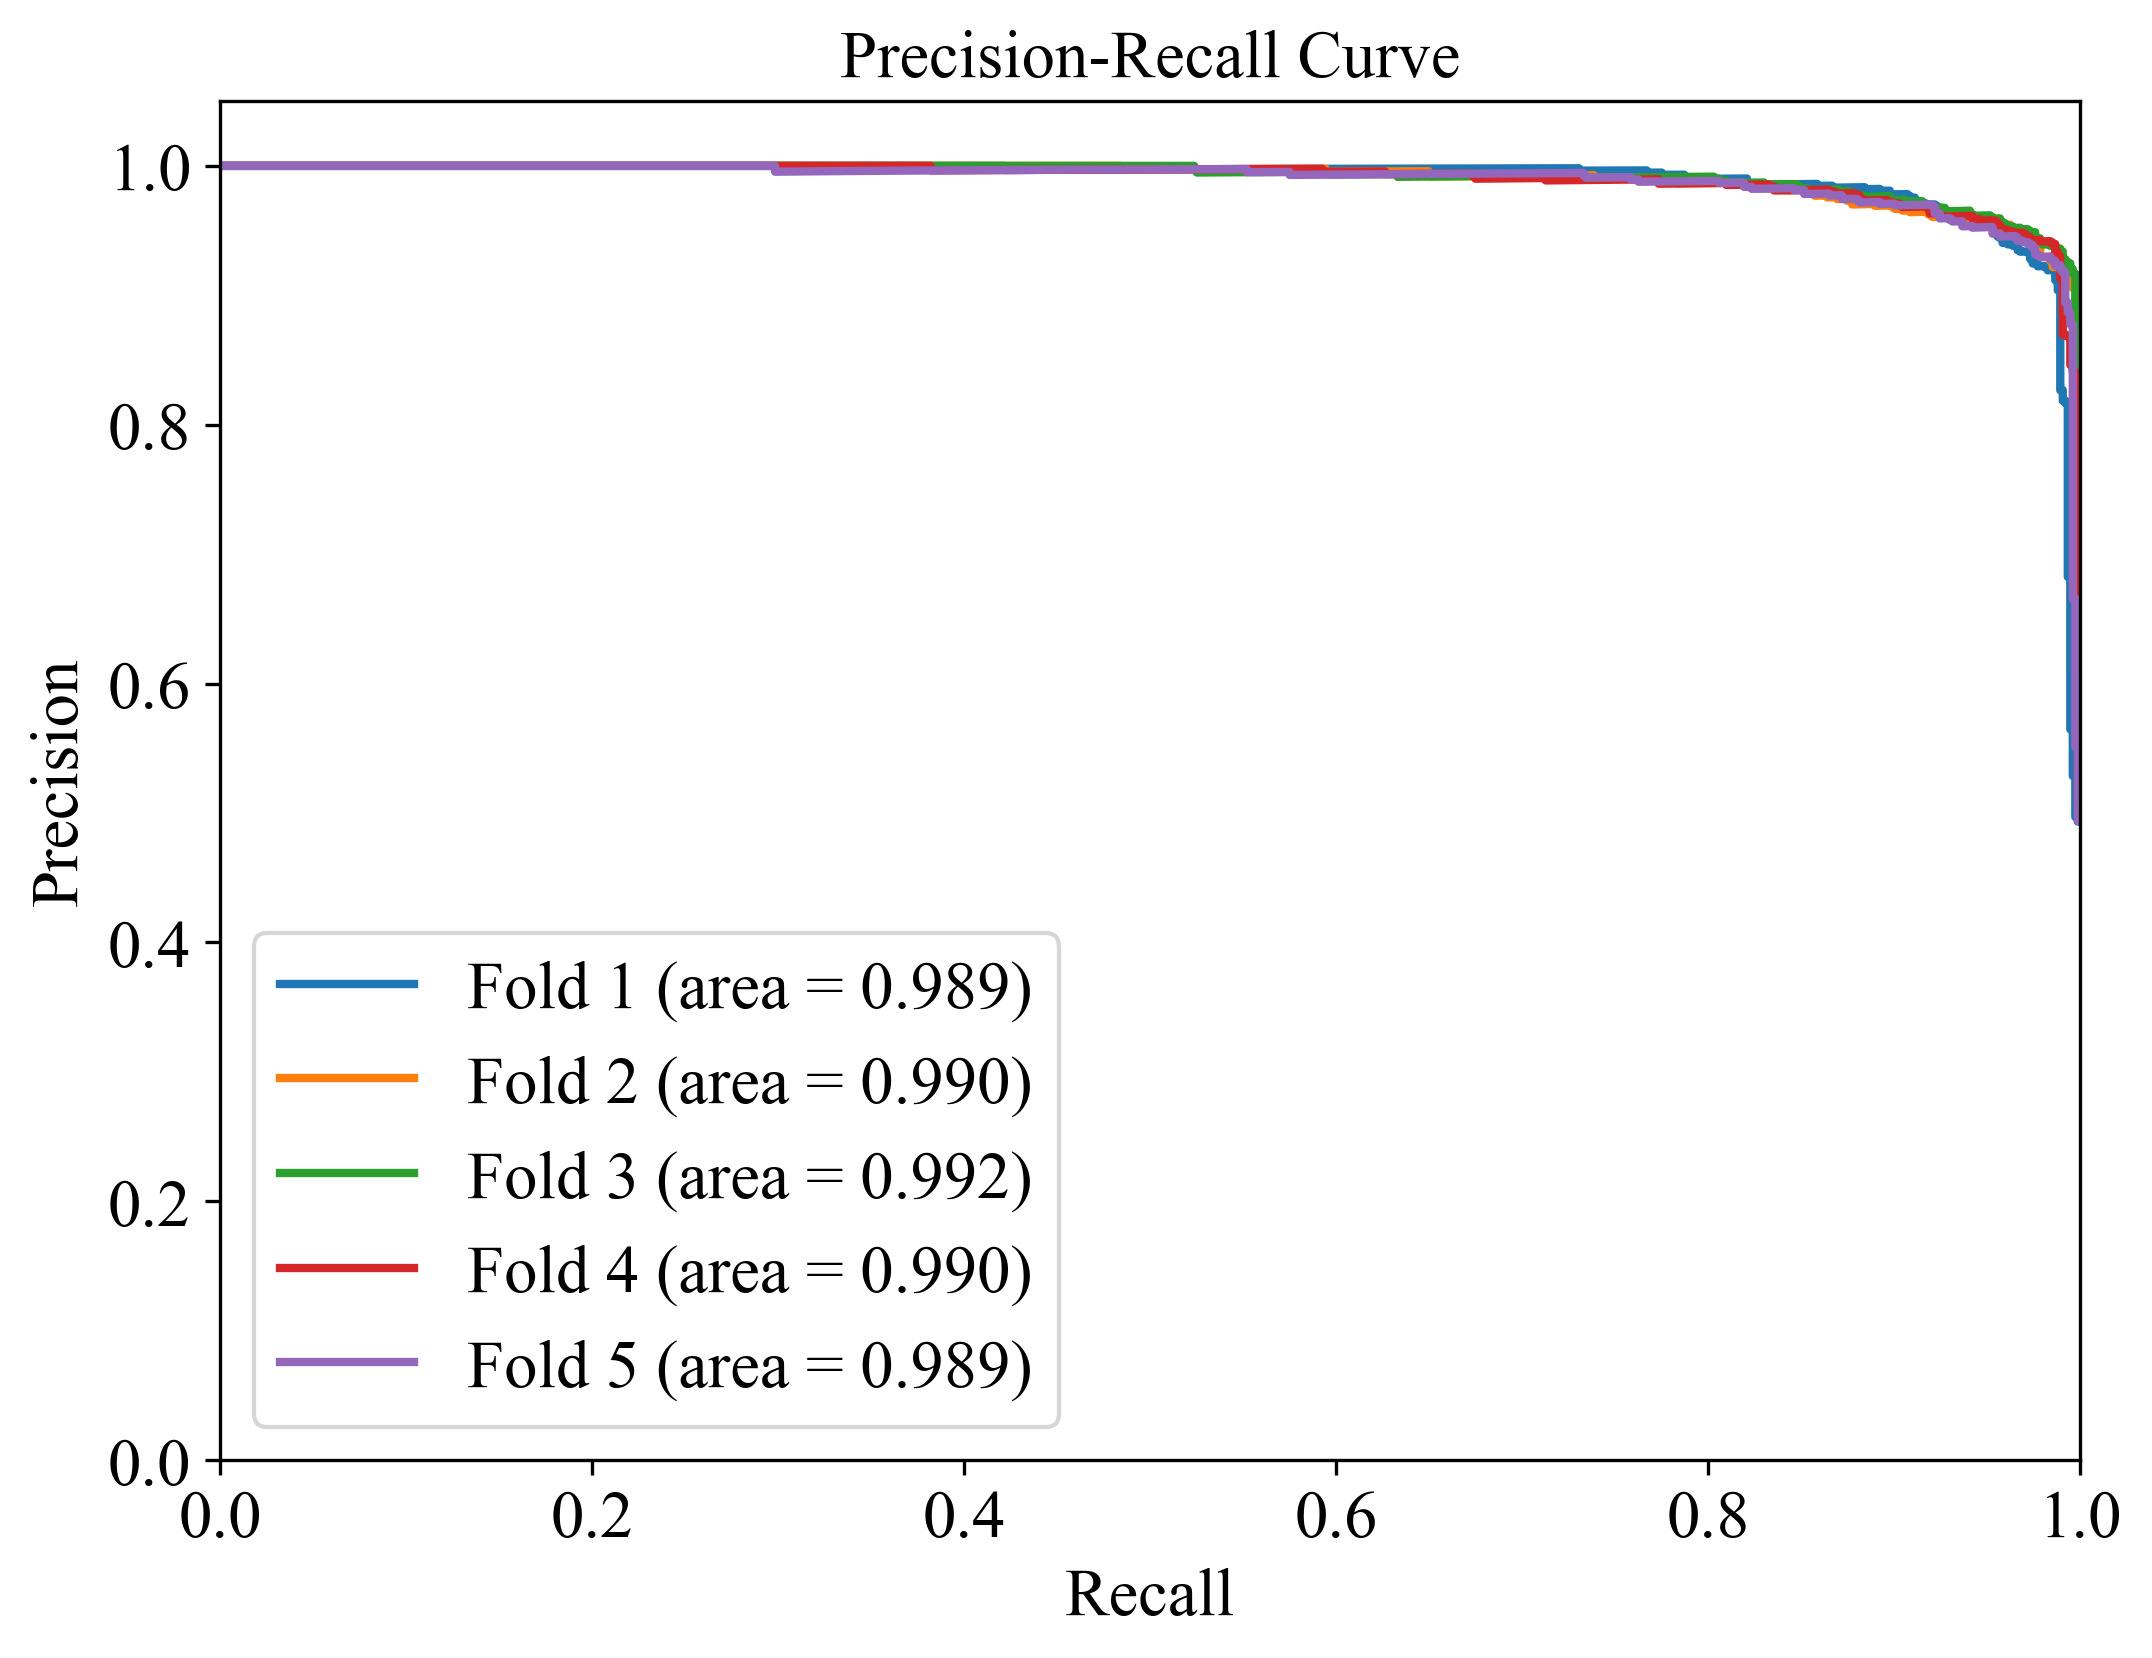

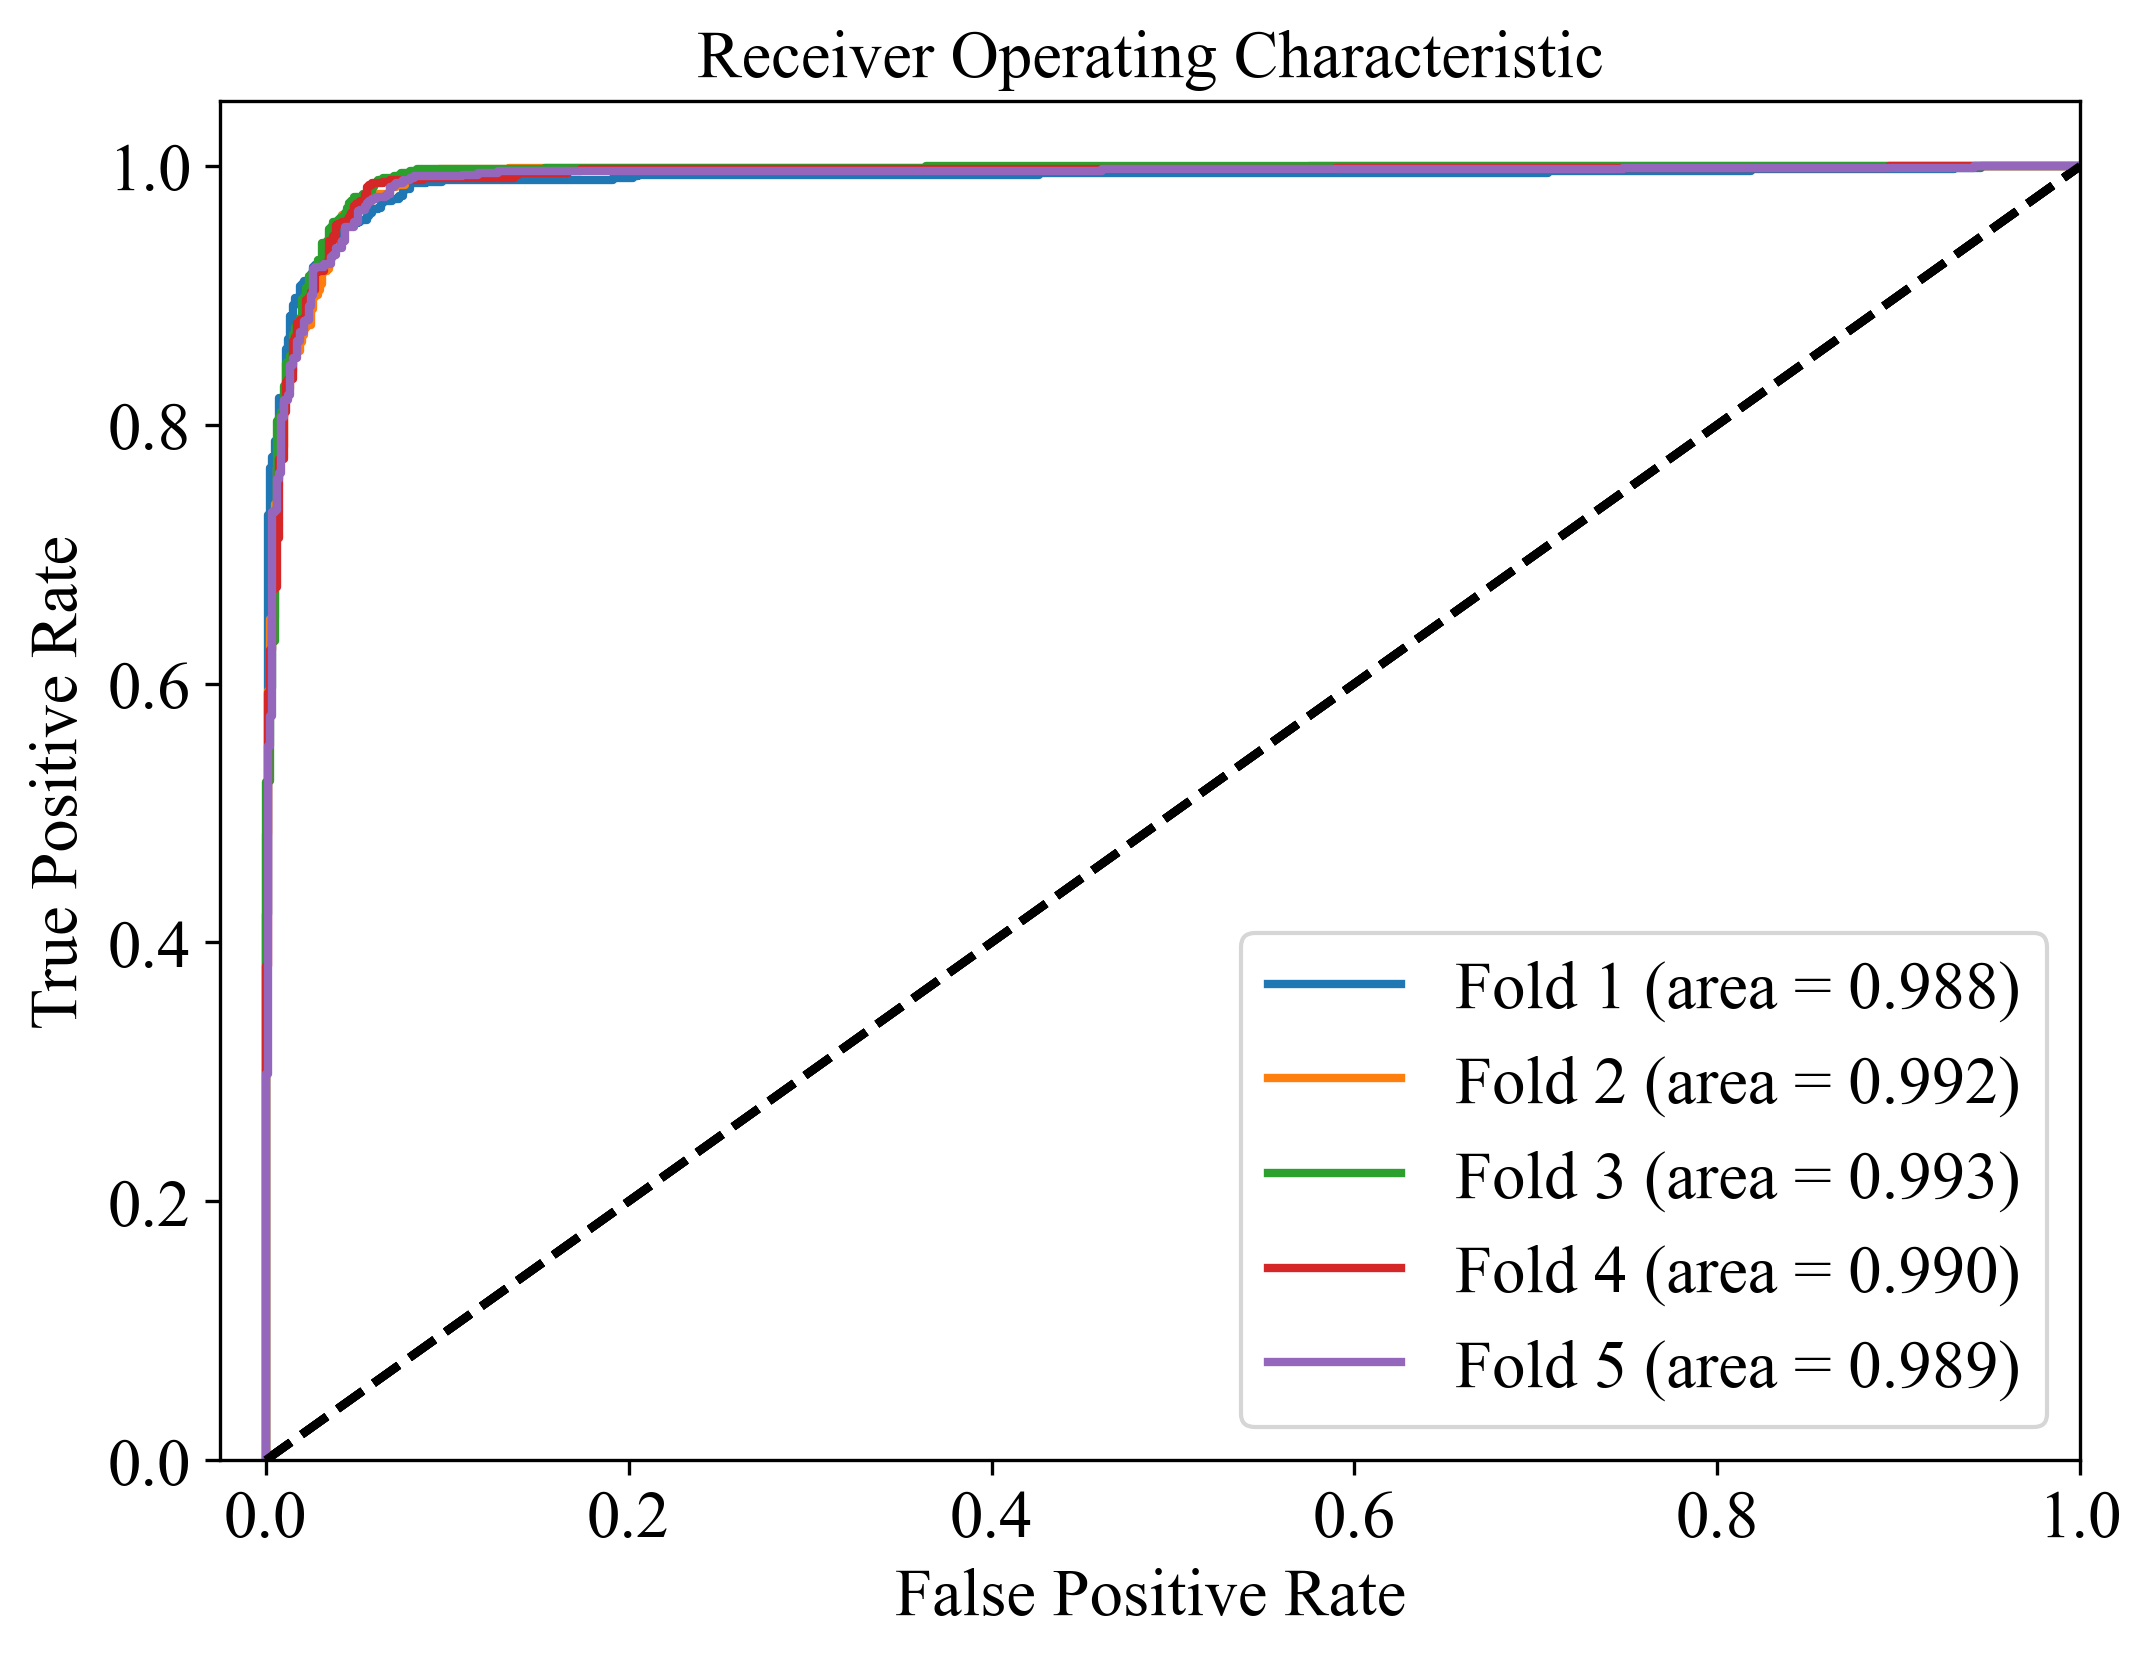

In [32]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
pr_fig, pr_ax = plt.subplots(figsize=(8, 6))
roc_fig, roc_ax = plt.subplots(figsize=(8, 6))
results_df = pd.DataFrame()
results_dicts = []
for i, (train_index, val_index) in enumerate(cv_indices):
    X_train_train, y_train_train = X_train.iloc[train_index], y_train.iloc[train_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
    clf = model
    clf.fit(X_train_train, y_train_train)
    y_score = clf.predict_proba(X_val)[:, 1]
    y_pred = clf.predict(X_val)
    y_val_col_name = f"y_val_{i+1}"
    y_score_col_name = f"y_score_{i+1}"
    y_val_series = pd.Series(y_val, name=y_val_col_name)
    y_score_series = pd.Series(y_score, name=y_score_col_name)
    results_df = pd.concat([results_df, y_val_series, y_score_series], axis=1)
   
    precision, recall, thresholds = precision_recall_curve(y_val, y_score)
    area = auc(recall, precision)
    pr_ax.plot(recall, precision, label='Fold %d (area = %0.3f)' % (i+1, area), lw=2)
    pr_ax.set_xlabel('Recall')
    pr_ax.set_ylabel('Precision')
    pr_ax.set_ylim([0.0, 1.05])
    pr_ax.set_xlim([0.0, 1.0])
    pr_ax.set_title('Precision-Recall Curve')
    pr_ax.legend(loc="lower left")
    

    fpr, tpr, thresholds = roc_curve(y_val, y_score)
    roc_auc = auc(fpr, tpr)
    roc_ax.plot(fpr, tpr, label='Fold %d (area = %0.3f)' % (i+1, roc_auc), lw=2)
    roc_ax.plot([0, 1], [0, 1], 'k--', lw=2)
    roc_ax.set_xlabel('False Positive Rate')
    roc_ax.set_ylabel('True Positive Rate')
    roc_ax.set_ylim([0.0, 1.05])
    roc_ax.set_xlim([-0.025, 1.0])
    roc_ax.set_title('Receiver Operating Characteristic')
    roc_ax.legend(loc="lower right")
    
    results_dicts.append({'model':model,"score":roc_auc})
    

pr_fig.savefig('./figures/figure2.png', dpi=300, bbox_inches='tight')
roc_fig.savefig('./figures/figure3.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
model = pd.DataFrame(results_dicts).sort_values("score",ascending=False).iloc[0]['model']

In [34]:
hse_data['is_metal'] = hse_data['HSE'].map(lambda x:1 if x==0 else 0)
hse_data['composition'] = hse_data['formula'].map(Composition)
hse_data_features = feature_calculators.featurize_dataframe(hse_data,col_id='composition',ignore_errors=True)[feature_labels]
if 'compound possible' in hse_data_features.columns:
    hse_data_features['compound possible'] = hse_data_features['compound possible'].map(lambda x: 1 if x else 0)
hse_data_pred = model.predict_proba(hse_data_features)[:,1]
fpr, tpr, thresholds = roc_curve(hse_data['is_metal'],hse_data_pred)
roc_auc = auc(fpr, tpr)

MultipleFeaturizer:   0%|          | 0/2204 [00:00<?, ?it/s]

In [35]:
hse_data_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2204 entries, 0 to 2906
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   2-norm                              2204 non-null   float64
 1   3-norm                              2204 non-null   float64
 2   MagpieData maximum Number           2143 non-null   float64
 3   MagpieData range Number             2143 non-null   float64
 4   MagpieData mean Number              2143 non-null   float64
 5   MagpieData maximum MendeleevNumber  2143 non-null   float64
 6   MagpieData mean MendeleevNumber     2143 non-null   float64
 7   MagpieData mode MendeleevNumber     2143 non-null   float64
 8   MagpieData maximum MeltingT         2142 non-null   float64
 9   MagpieData range MeltingT           2142 non-null   float64
 10  MagpieData range CovalentRadius     2143 non-null   float64
 11  MagpieData mean NdValence           2143 no

In [36]:
roc_auc

0.9736909164789905

In [37]:
y_test_pred = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test,y_test_pred)
roc_auc = auc(fpr, tpr)
roc_auc

0.9903021033322815

In [38]:
mp_data_non_U['composition'] = mp_data_non_U['formula'].map(Composition)
mp_data_non_U_features = feature_calculators.featurize_dataframe(mp_data_non_U,col_id='composition',ignore_errors=True)[feature_labels]
mp_data_non_U['is_metal'] = model.predict(mp_data_non_U_features)
mp_data_non_U_metal = mp_data_non_U[mp_data_non_U['is_metal']==1]
mp_data_U['target'] = mp_data_U['GGA']

MultipleFeaturizer:   0%|          | 0/91305 [00:00<?, ?it/s]

In [39]:
mp_data_non_U_metal['target'] = 0
mp_data_non_U_non_metal = mp_data_non_U[mp_data_non_U['is_metal']==0]
mp_data_non_U_non_metal_features = mp_data_non_U_features.drop(index=mp_data_non_U_metal.index)

# regression

In [40]:
data = data[data['HSE']>0]
data

,formula,spacegroup,HSE,GGA,composition,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum AtomicWeight,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData mode AtomicWeight,MagpieData minimum MeltingT,...,MagpieData maximum GSvolume_pa,MagpieData range GSvolume_pa,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData mode GSvolume_pa,MagpieData minimum GSbandgap,MagpieData maximum GSbandgap,MagpieData range GSbandgap,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData mode GSbandgap,MagpieData minimum GSmagmom,MagpieData maximum GSmagmom,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char
0,Ag(AuF4)2,14.0,2.060208,0.2585,"(Ag, Au, F)",3,0.755148,0.731509,0.727419,0.727279,0.727273,9.0,79.0,70.0,25.181818,23.537190,9.0,65.0,93.0,28.0,85.545455,10.842975,93.0,18.998403,196.966569,177.968166,59.435324,58.817339,18.998403,53.50,...,16.700000,6.992500,11.580909,2.724959,9.707500,0.0,1.970,1.970,1.432727,0.781488,1.970,0.0,0.000000,0.000000,0.000000,0.000000,0.0,15.0,225.0,210.0,72.272727,83.305785,15.0,1.727273,3.636364,2.727273,2.545455,False,0.650281,0.097953
7,Ag2AsS2,7.0,1.314572,0.5615,"(Ag, As, S)",3,0.600000,0.514256,0.460906,0.441882,0.428730,16.0,47.0,31.0,31.800000,12.640000,16.0,65.0,88.0,23.0,78.000000,10.400000,65.0,32.065000,107.868200,75.803200,70.957600,31.114080,32.065000,388.36,...,25.786875,9.456875,21.281750,3.961400,16.330000,0.0,2.202,2.202,0.880800,1.056960,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,70.0,225.0,155.0,151.200000,64.960000,70.0,1.600000,2.200000,6.000000,0.000000,False,0.100238,0.020415
8,Ag2Bi2S3Cl2,2.0,2.501266,1.6368,"(Ag, Bi, S, Cl)",4,0.509175,0.412048,0.356285,0.341126,0.335028,16.0,83.0,67.0,38.000000,24.000000,16.0,65.0,94.0,29.0,83.777778,8.345679,88.0,32.065000,208.980400,176.915400,88.977578,61.730420,32.065000,171.60,...,32.950000,16.620000,24.990625,4.068333,25.786875,0.0,2.493,2.493,1.288000,1.144889,2.202,0.0,0.000000,0.000000,0.000000,0.000000,0.0,12.0,225.0,213.0,90.222222,59.901235,70.0,1.777778,3.111111,4.444444,3.111111,True,0.314924,0.048336
9,Ag2BiO3,7.0,1.186643,0.5212,"(Ag, Bi, O)",3,0.623610,0.550321,0.512897,0.504110,0.500861,8.0,83.0,75.0,33.500000,25.500000,8.0,65.0,87.0,22.0,79.500000,9.666667,87.0,15.999400,208.980400,192.981000,78.785833,62.786433,15.999400,54.80,...,32.950000,23.845000,15.487500,6.382500,9.105000,0.0,0.000,0.000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,12.0,225.0,213.0,83.000000,94.666667,12.0,1.666667,2.500000,5.000000,2.333333,False,0.434489,0.105523
10,Ag2BiO3,34.0,1.129547,0.3872,"(Ag, Bi, O)",3,0.623610,0.550321,0.512897,0.504110,0.500861,8.0,83.0,75.0,33.500000,25.500000,8.0,65.0,87.0,22.0,79.500000,9.666667,87.0,15.999400,208.980400,192.981000,78.785833,62.786433,15.999400,54.80,...,32.950000,23.845000,15.487500,6.382500,9.105000,0.0,0.000,0.000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,12.0,225.0,213.0,83.000000,94.666667,12.0,1.666667,2.500000,5.000000,2.333333,False,0.434489,0.105523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [41]:
X = data.drop(columns = ['formula','HSE','composition'])
X = remove_collinear_features(X, 0.8);
feature_labels = X.columns

In [42]:
y = data['HSE']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [43]:
reg=lgb.LGBMRegressor(n_jobs=-1)
reg.fit(X_train,y_train)
feature_importance_reg=pd.DataFrame()
feature_importance_reg['features'] = feature_labels
feature_importance_reg['feature_importances'] = reg.feature_importances_

threshold = np.sort(feature_importance_reg['feature_importances'].values)
score = []
n_features = []
cols = []
for i in threshold:
    selector = SelectFromModel(reg,threshold=i)
    X_embedded = selector.fit_transform(X_train,y_train)
    once = cross_val_score(reg,X_embedded,y_train,cv=5,scoring="neg_mean_absolute_error",n_jobs=-1).mean()#交叉验证
    score.append(once)
    n_features.append(X_embedded.shape[1])
    cols.append(X_train.columns[selector.get_support()])
result = pd.DataFrame({"col":cols,"score":score,"n_features":n_features})
result

,col,score,n_features
0,"Index(['spacegroup', 'GGA', '0-norm', '2-norm'...",-0.241639,65
1,"Index(['spacegroup', 'GGA', '0-norm', '2-norm'...",-0.241639,65
2,"Index(['spacegroup', 'GGA', '0-norm', '2-norm'...",-0.241639,65
3,"Index(['spacegroup', 'GGA', '0-norm', '2-norm'...",-0.241639,65
4,"Index(['spacegroup', 'GGA', '0-norm', '2-norm'...",-0.241639,65
...,...,...,...
60,"Index(['GGA', 'MagpieData maximum Number', 'Ma...",-0.281166,5
61,"Index(['GGA', 'MagpieData maximum Number', 'Ma...",-0.299423,4
62,"Index(['GGA', 'MagpieData mean Number', 'Magpi...",-0.323413,3
63,"Index(['GGA', 'MagpieData mean Number'], dtype...",-0.345675,2


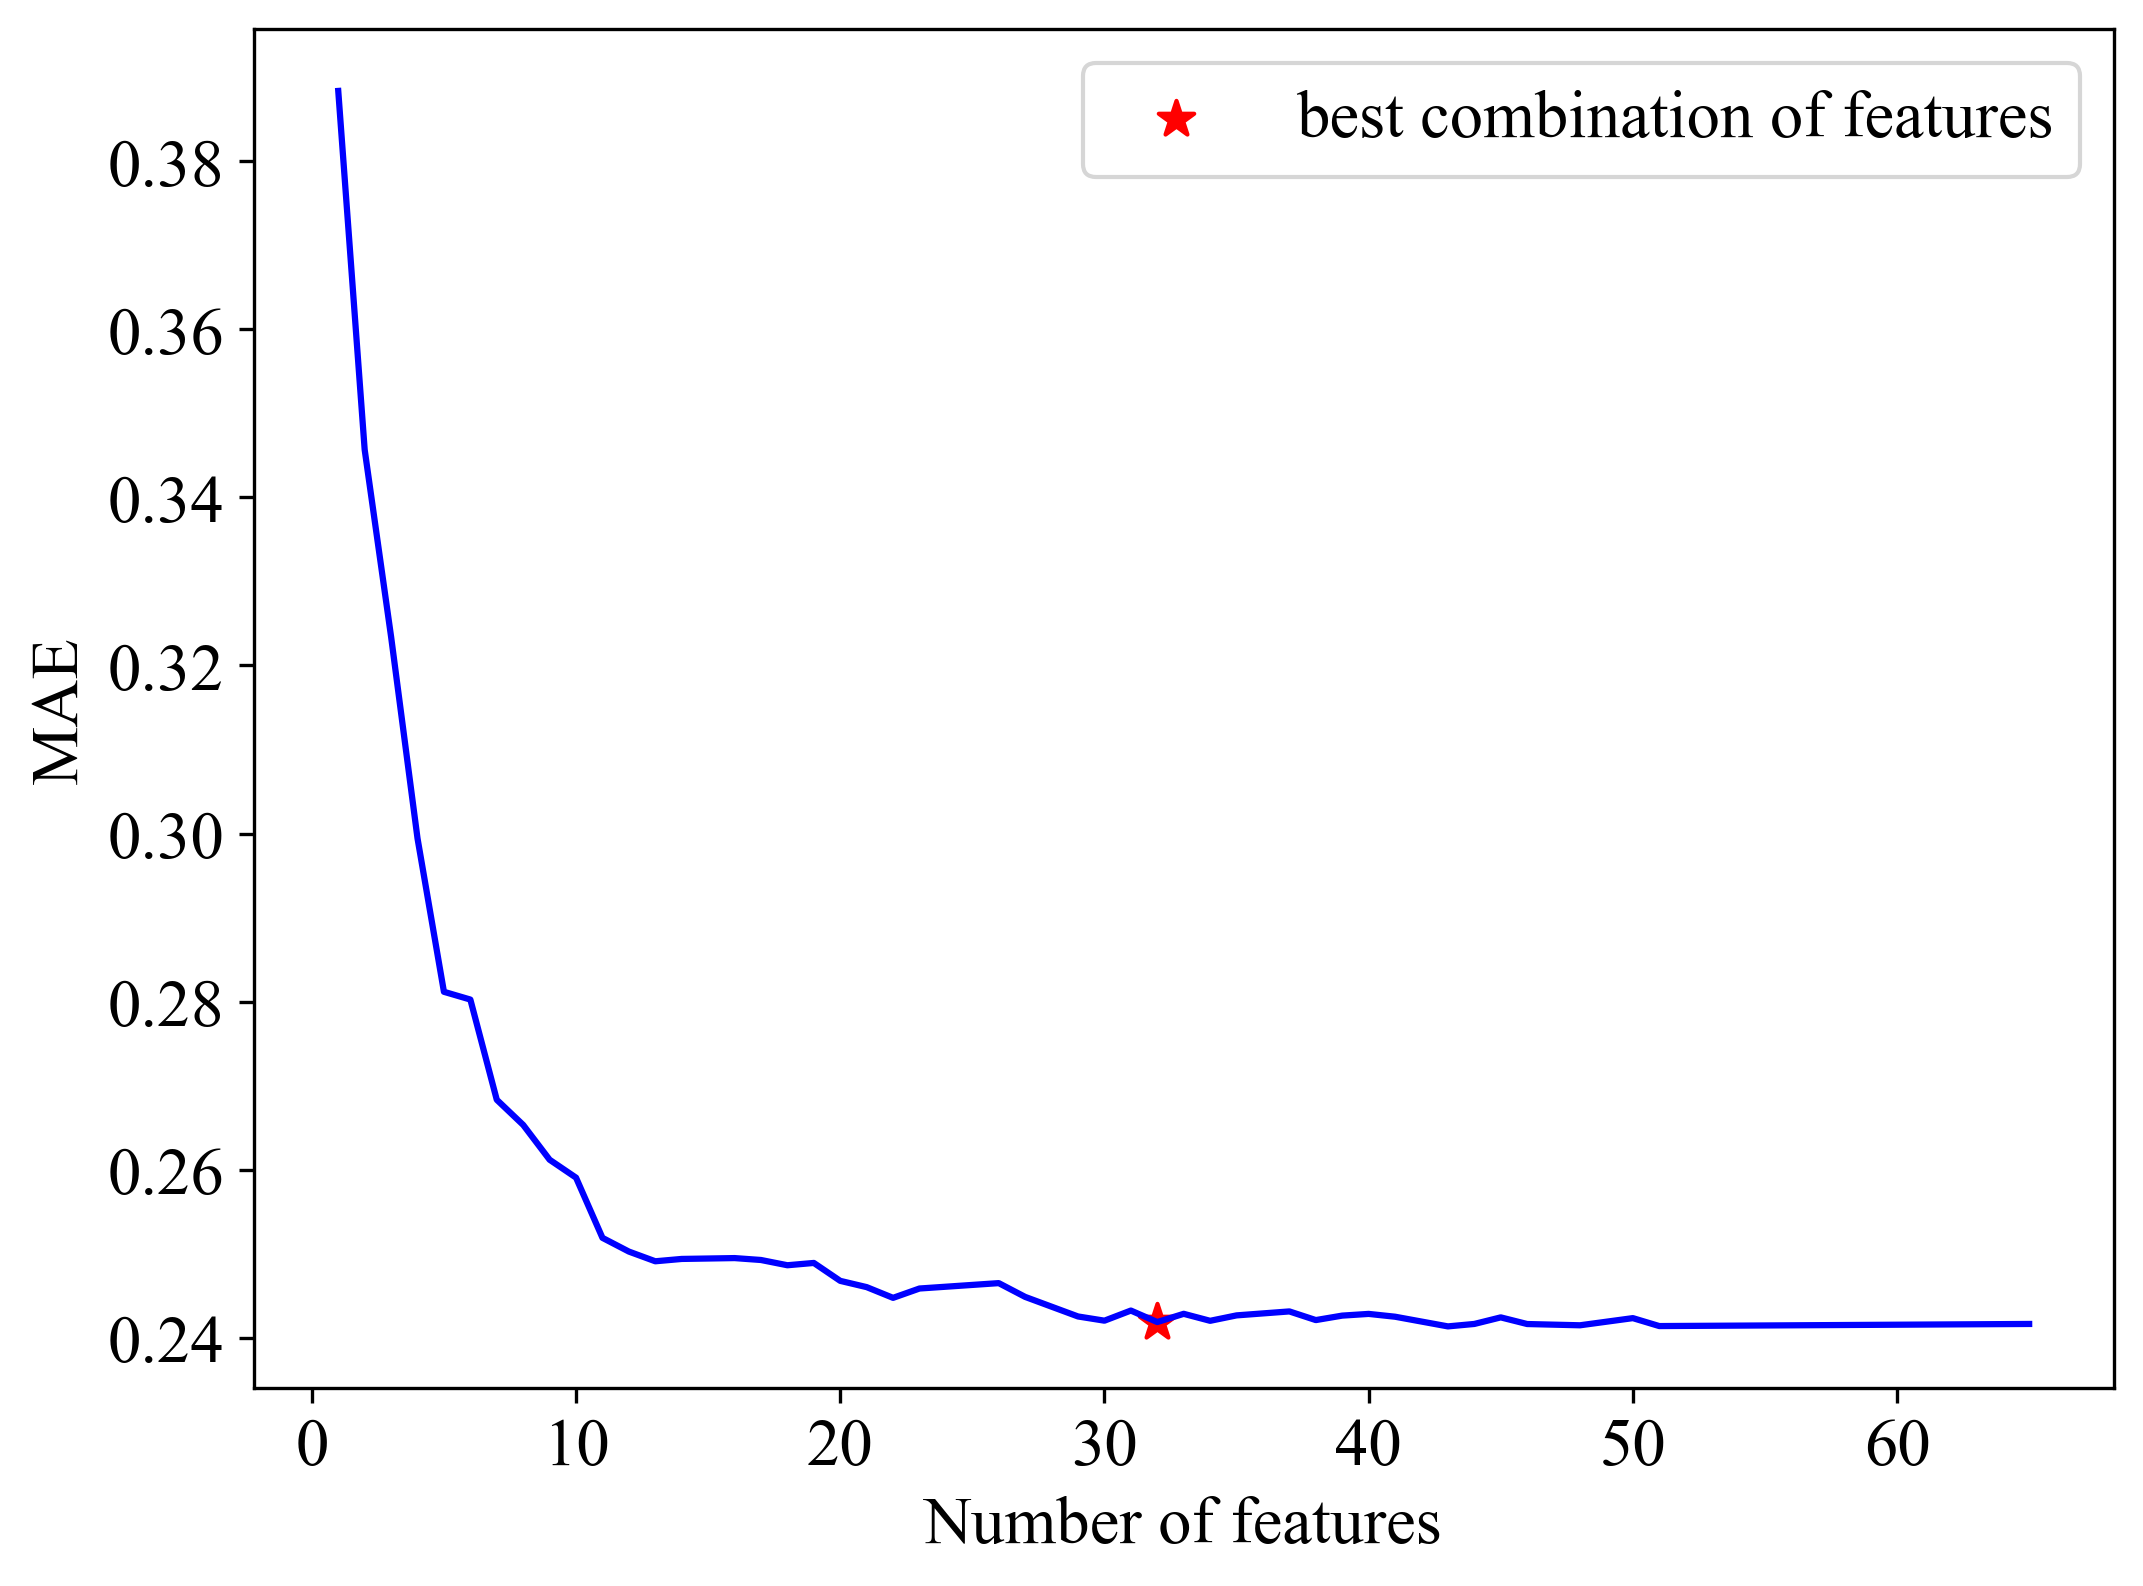

In [44]:
f_fig, f_ax = plt.subplots(figsize=(8, 6))
to_select = result[np.abs(result['score'])<0.242]
to_select = to_select.sort_values(by='n_features',ascending=True)
f_ax.scatter(to_select.iloc[0]['n_features'],-1*to_select.iloc[0]['score'],marker='*',
            s=80,c='r',label='best combination of features')
f_ax.plot(n_features,[-1*i for i in score], color='b')
f_ax.set_xlabel("Number of features"), plt.ylabel("MAE")
f_ax.legend()
plt.show()
f_fig.savefig('./figures/figure4.png', dpi=300, bbox_inches='tight')

In [45]:
feature_labels = to_select.iloc[0]['col']
X_train = X_train[feature_labels]
X_test = X_test[feature_labels]
X_train.shape, X_test.shape

((3978, 32), (995, 32))

In [46]:
def lgb_mae_cv(num_leaves, learning_rate, n_estimators, max_depth, min_child_sample, min_child_weight, subsample, colsample_bytree, reg_alpha, reg_lambda):
    model = lgb.LGBMRegressor(
        objective='regression',
        num_leaves=int(num_leaves),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_child_sample = int(min_child_sample),
        min_child_weight=int(min_child_weight),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
        n_jobs=-1,
    )
    score = cross_val_score(model,X_train,y_train,cv=5,scoring='neg_mean_absolute_error',n_jobs=-1).mean()

    return score

In [47]:
pbounds = {'num_leaves': (2, 100),
           'learning_rate': (0.001, 0.1),
           'n_estimators': (100, 2500),
           'max_depth': (1, 100),
           'min_child_sample':(1,100),
           'min_child_weight': (0.001,1),
           'subsample': (0.1, 1),
           'colsample_bytree': (0.1, 1),
           'reg_alpha': (0, 1),
           'reg_lambda': (0, 1)}

optimizer = BayesianOptimization(
    f=lgb_mae_cv,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(
    n_iter=100
)

print(optimizer.max) # 打印出找到的最佳参数组合和对应的分数

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.2443   | 0.4371    | 0.09512   | 73.47     | 60.27     | 0.1569    | 474.4     | 7.692     | 0.8662    | 0.6011    | 0.7373    |
| 2         | -0.4433   | 0.1185    | 0.09702   | 83.41     | 22.02     | 0.1826    | 540.2     | 31.82     | 0.5248    | 0.4319    | 0.3621    |
| 3         | -0.2372   | 0.6507    | 0.01481   | 29.92     | 37.27     | 0.4566    | 1.984e+03 | 21.57     | 0.5142    | 0.5924    | 0.1418    |
| 4         | -0.2413   | 0.6468    | 0.01788   | 7.44      | 94.94     | 0.9657    | 2.04e+03  | 31.85     | 0.09767   | 0.6842    | 0.4961    |
| 5         | -0.2773   | 0.2098    | 0.05002   | 4.404     | 91.02     | 0.2595    | 1.69e+03  | 32.55     | 0.5201    | 0.

| 34        | -0.2395   | 0.8536    | 0.01806   | 96.3      | 84.94     | 0.3457    | 2.015e+03 | 44.55     | 0.9615    | 0.5199    | 0.1406    |
| 35        | -0.3698   | 1.0       | 0.001     | 100.0     | 54.36     | 0.3576    | 1.99e+03  | 34.68     | 1.0       | 1.0       | 1.0       |
| 36        | -0.3143   | 0.2253    | 0.03639   | 72.65     | 99.42     | 0.2628    | 1.983e+03 | 44.47     | 0.3429    | 0.7792    | 0.1699    |
| 37        | -0.2419   | 0.834     | 0.03194   | 74.75     | 99.48     | 0.3379    | 2.037e+03 | 9.786     | 0.03716   | 0.9136    | 0.6064    |
| 38        | -0.2442   | 0.6058    | 0.0841    | 47.69     | 47.68     | 1.0       | 1.952e+03 | 10.74     | 0.395     | 0.04754   | 0.1       |
| 39        | -0.244    | 1.0       | 0.1       | 100.0     | 87.1      | 1.0       | 2.049e+03 | 32.79     | 0.4025    | 0.0       | 0.1       |
| 40        | -0.8353   | 0.3834    | 0.001     | 1.0       | 100.0     | 1.0       | 2.022e+03 | 69.16     | 0.1911    | 0.

| 68        | -0.3742   | 0.1       | 0.1       | 75.84     | 76.91     | 1.0       | 2.03e+03  | 30.62     | 0.0       | 1.0       | 1.0       |
| 69        | -0.2388   | 0.9115    | 0.05288   | 51.92     | 77.97     | 0.5852    | 921.3     | 36.08     | 0.9945    | 0.3447    | 0.4835    |
| 70        | -0.271    | 1.0       | 0.1       | 1.0       | 63.67     | 0.001     | 876.8     | 21.47     | 0.0       | 0.0       | 1.0       |
| 71        | -0.3977   | 0.1       | 0.1       | 57.56     | 50.95     | 0.001     | 932.1     | 44.85     | 0.0       | 1.0       | 0.1       |
| 72        | -0.2515   | 0.8684    | 0.07423   | 34.27     | 70.29     | 0.2675    | 1.967e+03 | 79.09     | 0.008913  | 0.1026    | 0.1008    |
| 73        | -0.241    | 0.9109    | 0.09976   | 35.09     | 75.0      | 0.897     | 964.1     | 26.86     | 0.6856    | 0.7313    | 0.4944    |
| 74        | -0.2386   | 1.0       | 0.04377   | 23.62     | 72.32     | 1.0       | 1.941e+03 | 11.86     | 1.0       | 0.

| 102       | -0.2419   | 0.8446    | 0.06913   | 70.67     | 99.39     | 0.7023    | 2.065e+03 | 21.42     | 0.4936    | 0.0476    | 0.3641    |
| 103       | -0.245    | 0.8591    | 0.06752   | 60.2      | 87.47     | 0.5112    | 1.88e+03  | 6.075     | 0.2332    | 0.8404    | 0.2589    |
| 104       | -0.2941   | 0.1       | 0.1       | 88.69     | 81.64     | 0.001008  | 1.908e+03 | 2.0       | 1.0       | 1.0       | 0.9983    |
| 105       | -0.2953   | 0.1       | 0.1       | 72.34     | 61.34     | 0.001     | 1.868e+03 | 2.0       | 0.0       | 1.0       | 0.1       |
{'target': -0.23627105240046897, 'params': {'colsample_bytree': 0.912338601907774, 'learning_rate': 0.026456149025389133, 'max_depth': 41.29629937879747, 'min_child_sample': 23.950350788782885, 'min_child_weight': 0.4053491666932412, 'n_estimators': 1866.8560947335711, 'num_leaves': 26.645701945582594, 'reg_alpha': 0.6660907380580748, 'reg_lambda': 0.9935564586054132, 'subsample': 0.9891623530047617}}


In [48]:
params = optimizer.max['params']
params['n_estimators'] = int(params['n_estimators'])
params['num_leaves'] = int(params['num_leaves'])
params['max_depth'] = int(params['max_depth'])
model = lgb.LGBMRegressor(
        objective='regression',
        **params,
        random_state=42,
        n_jobs=-1,
    )
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

In [49]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
textstr = f'test R2 = {r2_test:.2f}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}'
textstr

'test R2 = 0.96\nMAE = 0.23\nRMSE = 0.42'

In [50]:
y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)
textstr = f'test R2 = {r2_train:.2f}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}'
textstr

'test R2 = 1.00\nMAE = 0.07\nRMSE = 0.12'

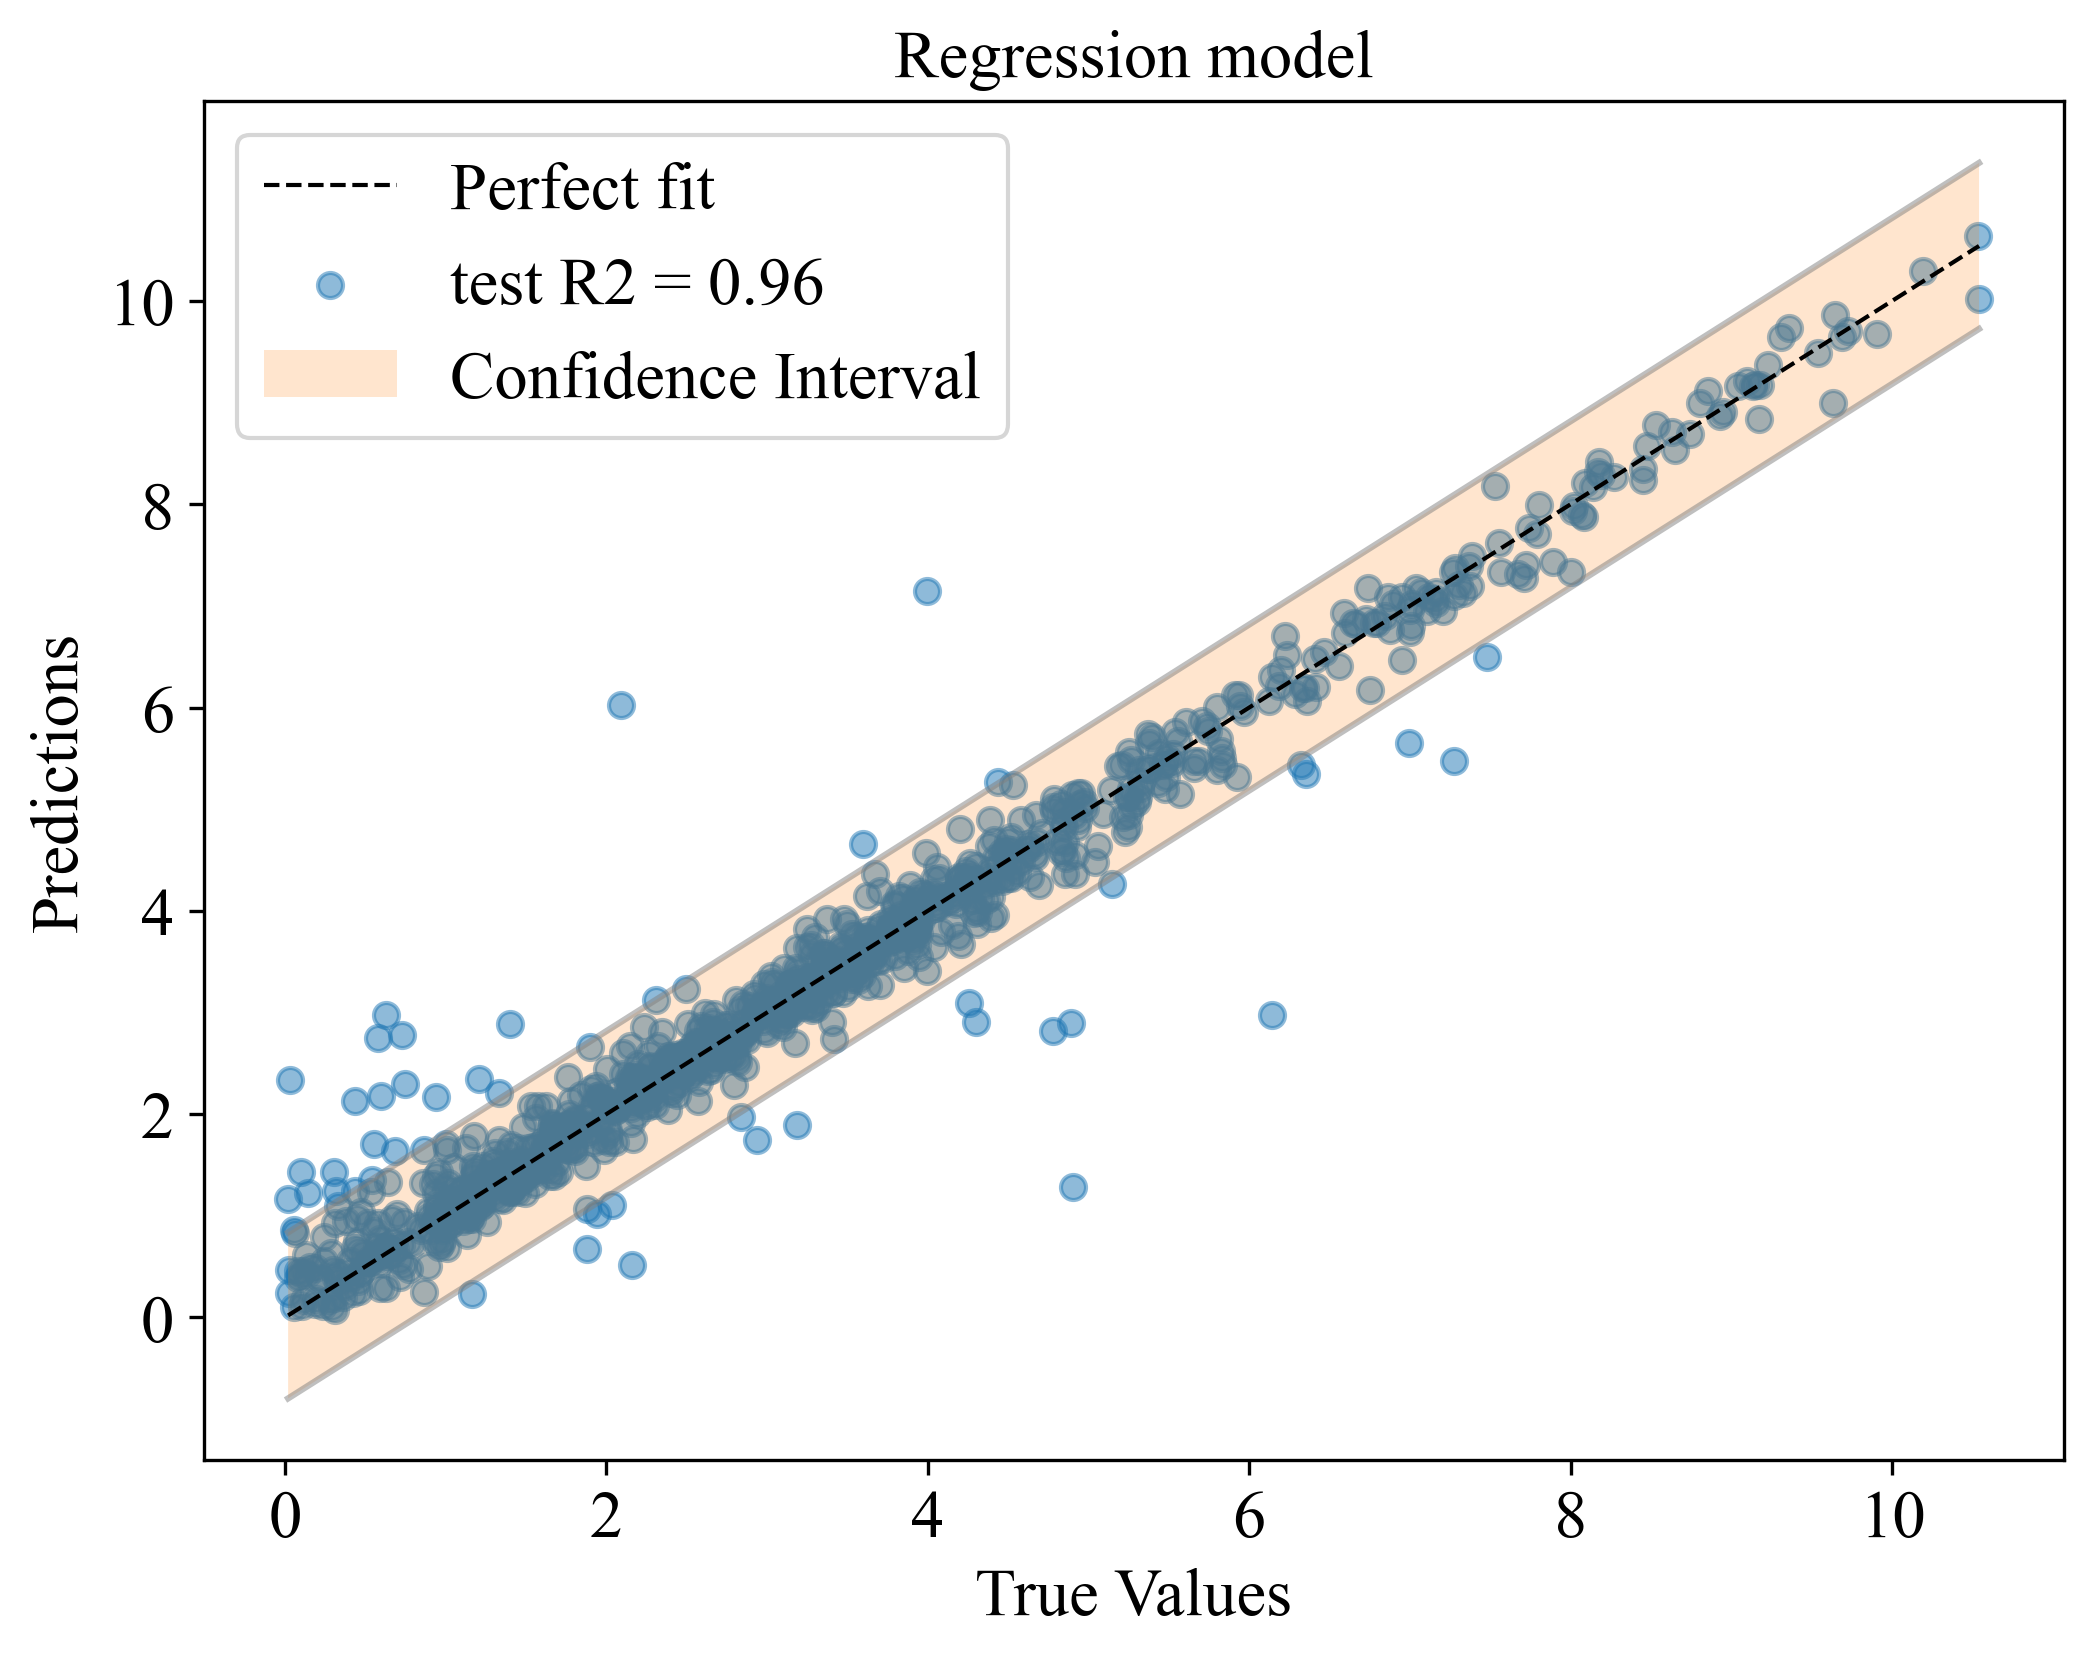

In [51]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5, label = f'test R2 = {r2_test:.2f}')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, label=f'Perfect fit')

residuals = y_test - y_pred

plt.fill_between([y_test.min(), y_test.max()], np.array([y_test.min(), y_test.max()]) - 1.96 * residuals.std(), 
                 np.array([y_test.min(), y_test.max()]) + 1.96 * residuals.std(), alpha=0.2,label='Confidence Interval')

plt.plot([y_test.min(), y_test.max()], np.array([y_test.min(), y_test.max()]) - 1.96 * residuals.std(), '-', color='grey',alpha=0.5)
plt.plot([y_test.min(), y_test.max()], np.array([y_test.min(), y_test.max()]) + 1.96 * residuals.std(), '-', color='grey',alpha=0.5)
plt.legend()


textstr = f'R2 = {r2_test:.2f}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}'

bbox = dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3',alpha=0.2)
#plt.text(0.75, 0.15, textstr, transform=plt.gca().transAxes, fontsize=12, 
         #verticalalignment='top', bbox=bbox)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Regression model')

plt.show()

In [52]:
hse_data_non_metal = hse_data[hse_data['is_metal']==0]
hse_data_non_metal_features = feature_calculators.featurize_dataframe(hse_data_non_metal,col_id='composition',ignore_errors=True)[feature_labels]
if 'compound possible' in hse_data_non_metal_features.columns:
    hse_data_non_metal_features['compound possible'] = hse_data_non_metal_features['compound possible'].map(lambda x: 1 if x else 0)
hse_pred = model.predict(hse_data_non_metal_features)
r2 = r2_score(hse_data_non_metal['HSE'], hse_pred)
mae = mean_absolute_error(hse_data_non_metal['HSE'], hse_pred)
rmse = mean_squared_error(hse_data_non_metal['HSE'], hse_pred, squared=False)
textstr = f'test R2 = {r2:.2f}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}'
textstr

MultipleFeaturizer:   0%|          | 0/1547 [00:00<?, ?it/s]

'test R2 = 0.81\nMAE = 0.44\nRMSE = 0.69'

In [53]:
mp_data_non_U_non_metal = mp_data_non_U[mp_data_non_U['is_metal']==0]
mp_data_non_U_non_metal_features = feature_calculators.featurize_dataframe(mp_data_non_U_non_metal,
                                                                 col_id='composition',ignore_errors=True)[feature_labels]
mp_data_non_U_non_metal['target'] = model.predict(mp_data_non_U_non_metal_features)
mp_data_non_U_non_metal

MultipleFeaturizer:   0%|          | 0/42969 [00:00<?, ?it/s]

,formula,spacegroup,GGA,formation_energy_per_atom,energy_above_hull,index,composition,is_GGA_U,is_metal,target
3,Mg149Tc,187,0.0978,-0.018674,0.000000,3.0,"(Mg, Tc)",0,0,0.867410
7,Ba6Y2Ga4O15,13,3.6041,-2.990437,0.000000,7.0,"(Ba, Y, Ga, O)",0,0,5.347446
8,CsRb2TlF6,225,3.6496,-2.631976,0.055559,8.0,"(Cs, Rb, Tl, F)",0,0,5.482466
19,Sb9S4F39,14,1.6685,-2.497372,0.000000,19.0,"(Sb, S, F)",0,0,3.075866
24,CSN2,7,1.0852,0.615691,0.724625,24.0,"(C, S, N)",0,0,3.049038
...,...,...,...,...,...,...,...,...,...,...
132137,ZrP2H4O9,14,2.9371,-2.420835,0.004328,NaN,"(Zr, P, H, O)",0,0,4.614880
99521,ZrS2O13,2,0.0000,-1.145342,0.473302,NaN,"(Zr, S, O)",0,0,2.761810
58703,ZrSCl6O,14,3.0288,-1.743575,0.000000,NaN,"(Zr, S, Cl, O)",0,0,4.450960
62317,ZrTi(PbO3)2,1,2.6348,-2.775653,0.028306,NaN,"(Zr, Ti, Pb, O)",0,0,3.806651


In [54]:
mp_data_non_U_non_metal = mp_data_non_U_non_metal[['formula','spacegroup','GGA','target']]
mp_data_non_U_non_metal

,formula,spacegroup,GGA,target
3,Mg149Tc,187,0.0978,0.867410
7,Ba6Y2Ga4O15,13,3.6041,5.347446
8,CsRb2TlF6,225,3.6496,5.482466
19,Sb9S4F39,14,1.6685,3.075866
24,CSN2,7,1.0852,3.049038
...,...,...,...,...
132137,ZrP2H4O9,14,2.9371,4.614880
99521,ZrS2O13,2,0.0000,2.761810
58703,ZrSCl6O,14,3.0288,4.450960
62317,ZrTi(PbO3)2,1,2.6348,3.806651


In [55]:
mp_data_non_U_metal = mp_data_non_U_metal[['formula','spacegroup','GGA','target']]
mp_data_non_U_metal

,formula,spacegroup,GGA,target
5,K2CuF4,142,0.0000,0
10,YCrB4,55,0.1589,0
12,ThGeS,139,0.0000,0
14,HfMnAl,38,0.0000,0
16,SiNi3W2,38,0.0000,0
...,...,...,...,...
40621,ZrSn,57,0.0000,0
14699,ZrSn,59,0.0000,0
7146,ZrTi2O,65,0.0000,0
61820,ZrVCo,38,0.0000,0


In [56]:
mp_data_U = mp_data_U[['formula','spacegroup','GGA','target']]
mp_data_U

,formula,spacegroup,GGA,target
1,Li2Mn3Cr3O12,10,0.0927,0.0927
6,Sr2HfWO6,225,0.0000,0.0000
30,Li9Ni15O28,2,0.0000,0.0000
33,Li2VSiO5,129,2.3621,2.3621
39,RbNa2Fe3P4ClO14,15,3.8946,3.8946
...,...,...,...,...
95324,Zr(MoO4)2,12,2.8250,2.8250
47760,Zr2Cr2F3,8,0.0000,0.0000
13477,Zr2Fe2F3,8,0.0000,0.0000
10003,Zr3FeF6,2,0.0000,0.0000


In [57]:
keeped_data['target'] = keeped_data['HSE']
keeped_data = keeped_data[['formula','spacegroup','GGA_y','target']]
keeped_data.columns = ['formula','spacegroup','GGA','target']
keeped_data

,formula,spacegroup,GGA,target
0,Ag(AuF4)2,14.0,0.2585,2.060208
1,Ag(Bi2S3)3,12.0,0.0000,0.000000
2,Ag(CO)2,15.0,0.7248,2.428665
3,Ag(Mo3Se4)2,148.0,0.0000,0.000000
4,Ag(MoSe)3,176.0,0.0000,0.000000
...,...,...,...,...
10647,ZrVGe,139.0,0.0000,0.000000
10648,ZrW2,227.0,0.0000,0.000000
10649,ZrZn,221.0,0.0000,0.000000
10650,ZrZn2,227.0,0.0000,0.000000


In [58]:
result_df = pd.concat([mp_data_U,mp_data_non_U_metal,mp_data_non_U_non_metal,keeped_data],axis=0).reset_index(drop=True)
result_df

,formula,spacegroup,GGA,target
0,Li2Mn3Cr3O12,10.0,0.0927,0.0927
1,Sr2HfWO6,225.0,0.0000,0.0000
2,Li9Ni15O28,2.0,0.0000,0.0000
3,Li2VSiO5,129.0,2.3621,2.3621
4,RbNa2Fe3P4ClO14,15.0,3.8946,3.8946
...,...,...,...,...
134248,ZrVGe,139.0,0.0000,0.0000
134249,ZrW2,227.0,0.0000,0.0000
134250,ZrZn,221.0,0.0000,0.0000
134251,ZrZn2,227.0,0.0000,0.0000


In [59]:
result_df.to_csv('./result/result.csv',index_label=0)